# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1368 × 296 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

Fitting estimator with 296 features.
building tree 5 of 100
building tree 2 of 100building tree 4 of 100

building tree 7 of 100
building tree 1 of 100
building tree 3 of 100
building tree 17 of 100
building tree 10 of 100
building tree 6 of 100
building tree 9 of 100
building tree 8 of 100building tree 19 of 100

building tree 12 of 100
building tree 16 of 100
building tree 11 of 100
building tree 21 of 100
building tree 15 of 100
building tree 25 of 100
building tree 26 of 100
building tree 22 of 100
building tree 14 of 100
building tree 27 of 100
building tree 18 of 100
building tree 13 of 100
building tree 24 of 100
building tree 28 of 100
building tree 30 of 100
building tree 20 of 100
building tree 29 of 100
building tree 23 of 100
building tree 35 of 100building tree 31 of 100

building tree 36 of 100
building tree 32 of 100
building tree 40 of 100
building tree 33 of 100
building tree 34 of 100
building tree 37 of 100
building tree 45 of 100building tree 42 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 44 of 100building tree 41 of 100

building tree 46 of 100

building tree 39 of 100building tree 47 of 100building tree 53 of 100


building tree 49 of 100building tree 48 of 100

building tree 51 of 100building tree 50 of 100

building tree 54 of 100building tree 52 of 100

building tree 55 of 100
building tree 56 of 100
building tree 59 of 100
building tree 58 of 100
building tree 57 of 100
building tree 60 of 100
building tree 64 of 100
building tree 65 of 100
building tree 62 of 100
building tree 61 of 100
building tree 63 of 100
building tree 66 of 100
building tree 74 of 100
building tree 68 of 100building tree 76 of 100
building tree 75 of 100

building tree 69 of 100
building tree 71 of 100building tree 80 of 100
building tree 67 of 100

building tree 72 of 100
building tree 73 of 100
building tree 81 of 100
building tree 79 of 100
building tree 83 of 100
building tree 70 of 100building tree 78 of 100

building tree 82 of 100building tree 77 of 100

building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 293 features.
building tree 6 of 100
building tree 2 of 100
building tree 5 of 100
building tree 1 of 100
building tree 3 of 100
building tree 4 of 100
building tree 15 of 100
building tree 10 of 100
building tree 16 of 100building tree 14 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 9 of 100
building tree 19 of 100
building tree 25 of 100
building tree 26 of 100
building tree 8 of 100
building tree 7 of 100
building tree 23 of 100
building tree 22 of 100
building tree 20 of 100
building tree 17 of 100
building tree 28 of 100
building tree 21 of 100
building tree 30 of 100
building tree 18 of 100
building tree 29 of 100
building tree 24 of 100
building tree 27 of 100
building tree 34 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 42 of 100building tree 36 of 100building tree 40 of 100


building tree 50 of 100building tree 51 of 100

building tree 41 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 43 of 100building tree 45 of 100
building tree 49 of 100

building tree 54 of 100

building tree 48 of 100building tree 52 of 100

building tree 58 of 100building tree 57 of 100
building tree 59 of 100
building tree 55 of 100building tree 60 of 100building tree 53 of 100



building tree 61 of 100
building tree 56 of 100
building tree 62 of 100
building tree 65 of 100
building tree 66 of 100
building tree 64 of 100
building tree 63 of 100
building tree 72 of 100building tree 76 of 100

building tree 73 of 100building tree 68 of 100building tree 70 of 100


building tree 71 of 100
building tree 82 of 100
building tree 67 of 100building tree 81 of 100

building tree 69 of 100
building tree 79 of 100
building tree 77 of 100building tree 78 of 100
building tree 75 of 100
building tree 74 of 100

building tree 80 of 100
building tree 83 of 100building tree 85 of 100building tree 87 of 100


building tree 89 of 100
building tree 88 of 100building tree 86 of 100building tree 84 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 290 features.
building tree 1 of 100
building tree 5 of 100
building tree 2 of 100
building tree 15 of 100
building tree 3 of 100
building tree 9 of 100
building tree 4 of 100
building tree 6 of 100
building tree 10 of 100
building tree 19 of 100
building tree 12 of 100
building tree 13 of 100
building tree 16 of 100
building tree 8 of 100
building tree 7 of 100
building tree 18 of 100
building tree 11 of 100
building tree 23 of 100
building tree 17 of 100
building tree 27 of 100
building tree 20 of 100
building tree 26 of 100
building tree 22 of 100
building tree 21 of 100
building tree 25 of 100
building tree 14 of 100
building tree 30 of 100
building tree 28 of 100
building tree 24 of 100
building tree 29 of 100
building tree 31 of 100
building tree 32 of 100
building tree 36 of 100
building tree 40 of 100
building tree 41 of 100building tree 35 of 100

building tree 44 of 100building tree 33 of 100
building tree 50 of 100building tree 49 of 100

building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 45 of 100building tree 42 of 100building tree 55 of 100

building tree 37 of 100building tree 38 of 100

building tree 43 of 100building tree 46 of 100
building tree 47 of 100building tree 48 of 100
building tree 53 of 100


building tree 58 of 100building tree 52 of 100building tree 39 of 100
building tree 54 of 100



building tree 59 of 100
building tree 51 of 100
building tree 56 of 100
building tree 57 of 100
building tree 60 of 100
building tree 62 of 100
building tree 61 of 100
building tree 64 of 100building tree 65 of 100

building tree 73 of 100building tree 69 of 100

building tree 66 of 100building tree 68 of 100building tree 71 of 100

building tree 63 of 100

building tree 67 of 100building tree 70 of 100

building tree 81 of 100building tree 75 of 100building tree 78 of 100

building tree 76 of 100

building tree 79 of 100building tree 77 of 100building tree 72 of 100


building tree 86 of 100building tree 74 of 100
building tree 80 of 100building tree 84 o

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 287 features.
building tree 5 of 100
building tree 7 of 100
building tree 1 of 100
building tree 6 of 100
building tree 10 of 100building tree 15 of 100

building tree 11 of 100
building tree 8 of 100
building tree 12 of 100
building tree 2 of 100
building tree 9 of 100
building tree 4 of 100
building tree 3 of 100
building tree 14 of 100
building tree 21 of 100
building tree 17 of 100
building tree 24 of 100
building tree 18 of 100
building tree 19 of 100
building tree 26 of 100
building tree 13 of 100
building tree 20 of 100
building tree 27 of 100
building tree 25 of 100
building tree 28 of 100
building tree 23 of 100
building tree 29 of 100
building tree 22 of 100
building tree 16 of 100
building tree 30 of 100
building tree 33 of 100
building tree 32 of 100
building tree 37 of 100building tree 35 of 100

building tree 39 of 100
building tree 38 of 100
building tree 41 of 100building tree 34 of 100

building tree 45 of 100building tree 36 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.





building tree 49 of 100building tree 47 of 100

building tree 53 of 100
building tree 44 of 100
building tree 59 of 100
building tree 56 of 100
building tree 55 of 100building tree 50 of 100

building tree 60 of 100building tree 57 of 100
building tree 51 of 100
building tree 58 of 100

building tree 61 of 100
building tree 64 of 100
building tree 62 of 100
building tree 65 of 100
building tree 63 of 100
building tree 67 of 100building tree 72 of 100

building tree 66 of 100building tree 68 of 100

building tree 71 of 100building tree 70 of 100
building tree 73 of 100building tree 78 of 100


building tree 82 of 100building tree 76 of 100
building tree 69 of 100
building tree 84 of 100

building tree 74 of 100building tree 77 of 100

building tree 75 of 100
building tree 83 of 100
building tree 81 of 100building tree 79 of 100

building tree 80 of 100building tree 85 of 100building tree 87 of 100


building tree 89 of 100building tree 86 of 100

building tree 90 of 100
building tree

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 284 features.
building tree 4 of 100
building tree 9 of 100
building tree 2 of 100
building tree 7 of 100
building tree 1 of 100
building tree 10 of 100
building tree 11 of 100
building tree 6 of 100
building tree 3 of 100
building tree 5 of 100
building tree 13 of 100
building tree 8 of 100
building tree 22 of 100
building tree 18 of 100
building tree 20 of 100
building tree 19 of 100
building tree 24 of 100
building tree 15 of 100
building tree 12 of 100
building tree 27 of 100
building tree 17 of 100
building tree 23 of 100building tree 29 of 100
building tree 26 of 100
building tree 16 of 100
building tree 25 of 100
building tree 28 of 100

building tree 14 of 100
building tree 21 of 100
building tree 30 of 100
building tree 33 of 100building tree 35 of 100
building tree 32 of 100

building tree 34 of 100
building tree 37 of 100
building tree 41 of 100
building tree 38 of 100building tree 36 of 100

building tree 31 of 100
building tree 40 of 100building tree

building tree 39 of 100
building tree 42 of 100
building tree 49 of 100building tree 48 of 100building tree 44 of 100
building tree 50 of 100
building tree 53 of 100


building tree 58 of 100building tree 47 of 100
building tree 57 of 100
building tree 51 of 100

building tree 45 of 100building tree 55 of 100building tree 52 of 100
building tree 54 of 100


building tree 59 of 100
building tree 56 of 100building tree 60 of 100

building tree 66 of 100building tree 61 of 100

building tree 62 of 100building tree 64 of 100

building tree 63 of 100
building tree 68 of 100building tree 67 of 100

building tree 71 of 100
building tree 79 of 100
building tree 73 of 100building tree 72 of 100

building tree 69 of 100
building tree 76 of 100building tree 65 of 100
building tree 74 of 100

building tree 70 of 100
building tree 78 of 100
building tree 85 of 100
building tree 81 of 100building tree 83 of 100building tree 84 of 100


building tree 80 of 100building tree 77 of 100

building tree 88

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 281 features.
building tree 3 of 100
building tree 2 of 100
building tree 9 of 100
building tree 8 of 100
building tree 12 of 100
building tree 7 of 100
building tree 10 of 100
building tree 1 of 100
building tree 16 of 100
building tree 18 of 100
building tree 5 of 100
building tree 20 of 100
building tree 11 of 100building tree 17 of 100
building tree 14 of 100

building tree 25 of 100
building tree 13 of 100
building tree 23 of 100
building tree 28 of 100
building tree 4 of 100
building tree 19 of 100
building tree 22 of 100
building tree 6 of 100
building tree 21 of 100
building tree 15 of 100
building tree 30 of 100
building tree 24 of 100
building tree 27 of 100building tree 26 of 100building tree 29 of 100


building tree 33 of 100
building tree 32 of 100
building tree 31 of 100building tree 44 of 100
building tree 43 of 100building tree 34 of 100


building tree 38 of 100building tree 39 of 100

building tree 35 of 100building tree 37 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 53 of 100
building tree 50 of 100
building tree 54 of 100
building tree 47 of 100
building tree 56 of 100building tree 40 of 100

building tree 55 of 100
building tree 48 of 100
building tree 58 of 100
building tree 60 of 100
building tree 59 of 100building tree 57 of 100

building tree 61 of 100
building tree 69 of 100
building tree 65 of 100building tree 64 of 100

building tree 62 of 100
building tree 67 of 100
building tree 63 of 100
building tree 66 of 100
building tree 68 of 100building tree 80 of 100building tree 73 of 100
building tree 71 of 100


building tree 74 of 100
building tree 75 of 100building tree 81 of 100

building tree 78 of 100building tree 70 of 100

building tree 83 of 100
building tree 79 of 100building tree 72 of 100
building tree 76 of 100building tree 82 of 100


building tree 84 of 100building tree 86 of 100

building tree 88 of 100building tree 85 of 100
building tree 77 of 100

building tree 87 of 100
building tree 89 of 100
building tree 92

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 278 features.
building tree 2 of 100
building tree 3 of 100
building tree 6 of 100
building tree 9 of 100
building tree 8 of 100
building tree 11 of 100
building tree 10 of 100
building tree 20 of 100
building tree 7 of 100
building tree 14 of 100
building tree 26 of 100
building tree 13 of 100building tree 5 of 100
building tree 4 of 100
building tree 16 of 100
building tree 1 of 100
building tree 23 of 100
building tree 25 of 100

building tree 15 of 100
building tree 21 of 100
building tree 12 of 100
building tree 19 of 100
building tree 27 of 100
building tree 28 of 100
building tree 30 of 100
building tree 24 of 100
building tree 18 of 100
building tree 22 of 100
building tree 29 of 100
building tree 17 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100
building tree 33 of 100building tree 35 of 100

building tree 37 of 100building tree 48 of 100

building tree 43 of 100building tree 42 of 100
building tree 40 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 55 of 100


building tree 54 of 100building tree 45 of 100building tree 38 of 100
building tree 49 of 100


building tree 59 of 100
building tree 57 of 100
building tree 50 of 100building tree 52 of 100building tree 56 of 100
building tree 46 of 100
building tree 39 of 100


building tree 58 of 100
building tree 60 of 100building tree 61 of 100

building tree 63 of 100
building tree 62 of 100
building tree 65 of 100building tree 69 of 100

building tree 70 of 100
building tree 67 of 100building tree 66 of 100

building tree 64 of 100
building tree 73 of 100
building tree 71 of 100building tree 74 of 100

building tree 76 of 100building tree 84 of 100

building tree 85 of 100
building tree 79 of 100building tree 75 of 100
building tree 80 of 100
building tree 72 of 100
building tree 81 of 100building tree 77 of 100


building tree 68 of 100building tree 78 of 100building tree 87 of 100
building tree 83 of 100


building tree 82 of 100building tree 86 of 100

building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 275 features.
building tree 9 of 100
building tree 5 of 100
building tree 3 of 100
building tree 4 of 100
building tree 2 of 100
building tree 7 of 100
building tree 6 of 100
building tree 1 of 100
building tree 14 of 100
building tree 18 of 100
building tree 10 of 100
building tree 13 of 100
building tree 17 of 100
building tree 27 of 100
building tree 8 of 100
building tree 12 of 100
building tree 11 of 100
building tree 21 of 100
building tree 23 of 100
building tree 20 of 100
building tree 16 of 100
building tree 15 of 100
building tree 26 of 100
building tree 28 of 100
building tree 22 of 100
building tree 25 of 100
building tree 19 of 100
building tree 24 of 100
building tree 30 of 100
building tree 29 of 100
building tree 33 of 100
building tree 32 of 100
building tree 36 of 100building tree 46 of 100building tree 38 of 100building tree 42 of 100

building tree 34 of 100

building tree 35 of 100
building tree 40 of 100

building tree 37 of 100
building tre



building tree 55 of 100building tree 47 of 100
building tree 50 of 100
building tree 54 of 100

building tree 44 of 100
building tree 52 of 100building tree 49 of 100building tree 57 of 100building tree 53 of 100

building tree 51 of 100
building tree 59 of 100


building tree 56 of 100building tree 58 of 100

building tree 60 of 100
building tree 61 of 100
building tree 68 of 100
building tree 65 of 100
building tree 69 of 100
building tree 66 of 100
building tree 63 of 100
building tree 71 of 100building tree 67 of 100building tree 74 of 100

building tree 70 of 100

building tree 78 of 100
building tree 72 of 100
building tree 84 of 100
building tree 80 of 100building tree 64 of 100
building tree 76 of 100
building tree 62 of 100

building tree 86 of 100building tree 75 of 100
building tree 79 of 100

building tree 89 of 100
building tree 77 of 100
building tree 83 of 100
building tree 87 of 100building tree 88 of 100

building tree 81 of 100
building tree 73 of 100building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 272 features.
building tree 3 of 100
building tree 2 of 100
building tree 7 of 100
building tree 5 of 100
building tree 8 of 100
building tree 13 of 100
building tree 10 of 100
building tree 12 of 100
building tree 1 of 100
building tree 6 of 100
building tree 14 of 100
building tree 16 of 100
building tree 24 of 100
building tree 11 of 100
building tree 15 of 100
building tree 18 of 100
building tree 23 of 100
building tree 4 of 100
building tree 17 of 100
building tree 22 of 100
building tree 21 of 100
building tree 28 of 100
building tree 9 of 100
building tree 29 of 100
building tree 19 of 100building tree 26 of 100

building tree 25 of 100
building tree 20 of 100
building tree 30 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 36 of 100building tree 35 of 100building tree 44 of 100
building tree 41 of 100

building tree 33 of 100

building tree 38 of 100building tree 45 of 100building tree 42 of 100

building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 53 of 100

building tree 55 of 100
building tree 50 of 100building tree 49 of 100building tree 52 of 100


building tree 56 of 100
building tree 59 of 100
building tree 58 of 100
building tree 60 of 100building tree 54 of 100

building tree 61 of 100
building tree 70 of 100
building tree 63 of 100
building tree 64 of 100building tree 67 of 100
building tree 62 of 100

building tree 69 of 100
building tree 65 of 100building tree 78 of 100
building tree 71 of 100

building tree 74 of 100building tree 79 of 100
building tree 81 of 100building tree 72 of 100building tree 68 of 100
building tree 75 of 100

building tree 66 of 100
building tree 83 of 100
building tree 73 of 100building tree 82 of 100

building tree 80 of 100building tree 76 of 100building tree 77 of 100


building tree 86 of 100
building tree 84 of 100


building tree 85 of 100
building tree 87 of 100building tree 88 of 100

building tree 89 of 100building tree 92 of 100

building tree 91 of 100
building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 269 features.
building tree 2 of 100
building tree 3 of 100
building tree 11 of 100
building tree 1 of 100building tree 10 of 100
building tree 6 of 100

building tree 4 of 100
building tree 7 of 100building tree 12 of 100

building tree 8 of 100
building tree 14 of 100
building tree 5 of 100
building tree 9 of 100
building tree 15 of 100
building tree 19 of 100
building tree 25 of 100
building tree 13 of 100
building tree 17 of 100
building tree 18 of 100
building tree 30 of 100
building tree 20 of 100
building tree 16 of 100
building tree 23 of 100
building tree 21 of 100
building tree 22 of 100
building tree 26 of 100
building tree 31 of 100building tree 28 of 100
building tree 29 of 100
building tree 27 of 100

building tree 33 of 100
building tree 34 of 100
building tree 32 of 100
building tree 24 of 100
building tree 38 of 100
building tree 36 of 100
building tree 35 of 100
building tree 39 of 100
building tree 41 of 100building tree 42 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100

building tree 48 of 100
building tree 57 of 100
building tree 47 of 100
building tree 46 of 100
building tree 59 of 100
building tree 51 of 100building tree 50 of 100

building tree 55 of 100building tree 53 of 100building tree 54 of 100


building tree 60 of 100building tree 56 of 100

building tree 61 of 100
building tree 64 of 100
building tree 58 of 100building tree 63 of 100
building tree 65 of 100building tree 52 of 100


building tree 68 of 100
building tree 67 of 100
building tree 62 of 100
building tree 66 of 100
building tree 72 of 100building tree 73 of 100
building tree 69 of 100
building tree 76 of 100

building tree 75 of 100
building tree 70 of 100
building tree 74 of 100
building tree 71 of 100building tree 81 of 100

building tree 78 of 100
building tree 79 of 100building tree 83 of 100

building tree 77 of 100
building tree 80 of 100
building tree 88 of 100building tree 85 of 100

building tree 87 of 100building tree 82 of 100

building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 266 features.
building tree 1 of 100
building tree 2 of 100
building tree 4 of 100
building tree 8 of 100
building tree 15 of 100
building tree 3 of 100
building tree 11 of 100
building tree 9 of 100
building tree 7 of 100
building tree 5 of 100
building tree 10 of 100building tree 6 of 100

building tree 17 of 100
building tree 13 of 100
building tree 21 of 100
building tree 18 of 100
building tree 25 of 100
building tree 16 of 100building tree 20 of 100
building tree 23 of 100

building tree 12 of 100
building tree 14 of 100
building tree 24 of 100
building tree 19 of 100
building tree 22 of 100
building tree 29 of 100
building tree 27 of 100
building tree 30 of 100
building tree 28 of 100
building tree 26 of 100
building tree 31 of 100
building tree 35 of 100
building tree 32 of 100
building tree 37 of 100building tree 34 of 100

building tree 45 of 100
building tree 33 of 100
building tree 41 of 100
building tree 42 of 100
building tree 44 of 100building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.




building tree 49 of 100
building tree 54 of 100building tree 46 of 100

building tree 57 of 100
building tree 56 of 100
building tree 53 of 100
building tree 52 of 100
building tree 55 of 100building tree 58 of 100

building tree 60 of 100
building tree 59 of 100
building tree 61 of 100
building tree 62 of 100building tree 63 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100

building tree 68 of 100
building tree 64 of 100building tree 69 of 100

building tree 70 of 100
building tree 74 of 100
building tree 77 of 100building tree 73 of 100
building tree 81 of 100
building tree 78 of 100building tree 71 of 100


building tree 72 of 100building tree 84 of 100

building tree 76 of 100
building tree 79 of 100
building tree 82 of 100building tree 75 of 100

building tree 80 of 100building tree 83 of 100

building tree 85 of 100
building tree 90 of 100
building tree 87 of 100
building tree 89 of 100building tree 86 of 100building tree 88 of 100
building tree 92

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 263 features.
building tree 4 of 100
building tree 3 of 100
building tree 5 of 100
building tree 16 of 100
building tree 7 of 100
building tree 13 of 100
building tree 2 of 100
building tree 12 of 100
building tree 10 of 100building tree 9 of 100

building tree 6 of 100
building tree 20 of 100
building tree 21 of 100
building tree 17 of 100
building tree 1 of 100
building tree 18 of 100
building tree 19 of 100
building tree 8 of 100building tree 11 of 100
building tree 26 of 100
building tree 14 of 100

building tree 15 of 100
building tree 23 of 100
building tree 25 of 100
building tree 24 of 100
building tree 27 of 100
building tree 28 of 100
building tree 22 of 100
building tree 29 of 100
building tree 30 of 100
building tree 41 of 100
building tree 33 of 100building tree 31 of 100
building tree 39 of 100
building tree 35 of 100building tree 36 of 100
building tree 34 of 100


building tree 48 of 100building tree 32 of 100
building tree 37 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 53 of 100building tree 54 of 100

building tree 49 of 100
building tree 56 of 100
building tree 59 of 100
building tree 57 of 100building tree 55 of 100

building tree 60 of 100building tree 58 of 100

building tree 64 of 100
building tree 66 of 100building tree 65 of 100building tree 63 of 100

building tree 70 of 100
building tree 62 of 100

building tree 61 of 100building tree 67 of 100building tree 73 of 100


building tree 69 of 100building tree 75 of 100
building tree 71 of 100
building tree 74 of 100

building tree 79 of 100
building tree 78 of 100
building tree 83 of 100
building tree 80 of 100
building tree 76 of 100
building tree 85 of 100
building tree 68 of 100building tree 82 of 100
building tree 87 of 100
building tree 77 of 100
building tree 72 of 100

building tree 81 of 100
building tree 84 of 100
building tree 86 of 100
building tree 90 of 100
building tree 89 of 100
building tree 88 of 100building tree 91 of 100

building tree 93 of 100
building tree 94

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 260 features.
building tree 2 of 100
building tree 7 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 1 of 100
building tree 12 of 100building tree 18 of 100

building tree 10 of 100
building tree 6 of 100
building tree 11 of 100building tree 8 of 100

building tree 17 of 100
building tree 14 of 100
building tree 26 of 100
building tree 27 of 100
building tree 13 of 100
building tree 9 of 100
building tree 20 of 100
building tree 21 of 100
building tree 25 of 100
building tree 16 of 100
building tree 15 of 100
building tree 19 of 100
building tree 29 of 100
building tree 24 of 100
building tree 23 of 100
building tree 30 of 100building tree 28 of 100

building tree 22 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100
building tree 35 of 100building tree 33 of 100

building tree 36 of 100
building tree 37 of 100
building tree 39 of 100
building tree 41 of 100building tree 40 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 56 of 100
building tree 42 of 100building tree 46 of 100
building tree 49 of 100

building tree 55 of 100building tree 54 of 100building tree 50 of 100
building tree 52 of 100


building tree 51 of 100
building tree 53 of 100
building tree 57 of 100
building tree 58 of 100
building tree 61 of 100
building tree 48 of 100building tree 62 of 100

building tree 59 of 100
building tree 60 of 100
building tree 64 of 100
building tree 63 of 100
building tree 66 of 100
building tree 67 of 100building tree 65 of 100

building tree 82 of 100
building tree 73 of 100building tree 70 of 100

building tree 68 of 100building tree 72 of 100building tree 69 of 100


building tree 77 of 100
building tree 83 of 100
building tree 71 of 100
building tree 81 of 100building tree 76 of 100building tree 79 of 100building tree 75 of 100



building tree 78 of 100
building tree 74 of 100building tree 84 of 100
building tree 85 of 100

building tree 88 of 100
building tree 80 of 100building tree 87 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 257 features.
building tree 8 of 100
building tree 5 of 100
building tree 13 of 100
building tree 7 of 100
building tree 16 of 100
building tree 2 of 100
building tree 1 of 100
building tree 6 of 100
building tree 9 of 100
building tree 23 of 100
building tree 19 of 100
building tree 4 of 100
building tree 14 of 100
building tree 22 of 100
building tree 18 of 100
building tree 15 of 100
building tree 20 of 100
building tree 24 of 100
building tree 25 of 100
building tree 28 of 100
building tree 3 of 100
building tree 12 of 100
building tree 10 of 100
building tree 17 of 100
building tree 30 of 100
building tree 21 of 100
building tree 27 of 100
building tree 11 of 100
building tree 26 of 100
building tree 29 of 100
building tree 32 of 100
building tree 33 of 100building tree 31 of 100building tree 35 of 100
building tree 40 of 100building tree 45 of 100

building tree 39 of 100

building tree 44 of 100building tree 43 of 100building tree 37 of 100building tree 34

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.




building tree 57 of 100building tree 46 of 100building tree 48 of 100building tree 51 of 100building tree 53 of 100building tree 47 of 100


building tree 59 of 100
building tree 52 of 100
building tree 56 of 100
building tree 54 of 100



building tree 61 of 100
building tree 60 of 100
building tree 68 of 100building tree 62 of 100

building tree 63 of 100
building tree 64 of 100building tree 75 of 100

building tree 74 of 100building tree 70 of 100
building tree 80 of 100

building tree 66 of 100
building tree 72 of 100
building tree 69 of 100
building tree 76 of 100building tree 78 of 100
building tree 87 of 100building tree 65 of 100


building tree 86 of 100building tree 67 of 100
building tree 71 of 100building tree 77 of 100
building tree 84 of 100

building tree 82 of 100

building tree 79 of 100building tree 85 of 100
building tree 73 of 100
building tree 83 of 100

building tree 81 of 100
building tree 90 of 100building tree 88 of 100

building tree 89 of 100building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 254 features.
building tree 6 of 100
building tree 13 of 100building tree 4 of 100

building tree 2 of 100
building tree 3 of 100
building tree 7 of 100
building tree 8 of 100
building tree 14 of 100
building tree 9 of 100
building tree 5 of 100
building tree 1 of 100
building tree 11 of 100
building tree 12 of 100
building tree 24 of 100building tree 18 of 100

building tree 17 of 100

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 16 of 100
building tree 15 of 100
building tree 22 of 100

building tree 10 of 100
building tree 28 of 100
building tree 25 of 100
building tree 20 of 100
building tree 19 of 100
building tree 23 of 100
building tree 27 of 100
building tree 26 of 100
building tree 21 of 100
building tree 29 of 100
building tree 30 of 100
building tree 37 of 100
building tree 40 of 100
building tree 31 of 100
building tree 34 of 100
building tree 38 of 100building tree 36 of 100building tree 33 of 100

building tree 44 of 100
building tree 41 of 100
building tree 32 of 100

building tree 39 of 100building tree 43 of 100building tree 42 of 100

building tree 46 of 100
building tree 45 of 100

building tree 35 of 100building tree 48 of 100

building tree 51 of 100
building tree 56 of 100building tree 49 of 100building tree 52 of 100

building tree 53 of 100building tree 47 of 100

building tree 50 of 100

building tree 54 of 100
building tree 57 of 100
building tree 60 of 100building tree 59

building tree 85 of 100

building tree 91 of 100
building tree 89 of 100building tree 86 of 100building tree 90 of 100

building tree 83 of 100

building tree 92 of 100
building tree 99 of 100building tree 97 of 100building tree 94 of 100


building tree 98 of 100
building tree 95 of 100
building tree 100 of 100
building tree 93 of 100building tree 96 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 251 features.
building tree 2 of 100
building tree 5 of 100
building tree 6 of 100
building tree 4 of 100
building tree 1 of 100
building tree 13 of 100
building tree 11 of 100
building tree 9 of 100
building tree 7 of 100
building tree 10 of 100
building tree 8 of 100
building tree 12 of 100
building tree 16 of 100
building tree 15 of 100
building tree 18 of 100
building tree 22 of 100
building tree 14 of 100
building tree 3 of 100
building tree 17 of 100
building tree 19 of 100building tree 20 of 100

building tree 21 of 100
building tree 27 of 100
building tree 28 of 100
building tree 26 of 100
building tree 29 of 100
building tree 25 of 100
building tree 30 of 100
building tree 23 of 100
building tree 24 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 37 of 100
building tree 41 of 100
building tree 36 of 100
building tree 46 of 100building tree 40 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 45 of 100building tree 52 of 100

building tree 56 of 100
building tree 39 of 100building tree 50 of 100building tree 54 of 100


building tree 57 of 100
building tree 55 of 100
building tree 59 of 100
building tree 47 of 100
building tree 58 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 75 of 100building tree 66 of 100

building tree 67 of 100building tree 64 of 100building tree 72 of 100
building tree 65 of 100


building tree 69 of 100building tree 68 of 100

building tree 73 of 100
building tree 70 of 100building tree 79 of 100

building tree 81 of 100building tree 76 of 100

building tree 71 of 100
building tree 84 of 100
building tree 74 of 100building tree 85 of 100
building tree 80 of 100
building tree 78 of 100

building tree 77 of 100
building tree 83 of 100building tree 82 of 100

building tree 87 of 100
building tree 88 of 100building tree 89 of 100

building tree 91 of 100
building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 248 features.
building tree 4 of 100
building tree 2 of 100
building tree 5 of 100
building tree 7 of 100
building tree 3 of 100building tree 1 of 100
building tree 9 of 100
building tree 6 of 100

building tree 13 of 100
building tree 8 of 100
building tree 12 of 100
building tree 10 of 100
building tree 18 of 100
building tree 17 of 100
building tree 16 of 100
building tree 23 of 100
building tree 19 of 100
building tree 25 of 100
building tree 20 of 100
building tree 14 of 100
building tree 11 of 100
building tree 30 of 100
building tree 24 of 100
building tree 15 of 100
building tree 21 of 100
building tree 22 of 100
building tree 26 of 100
building tree 28 of 100
building tree 27 of 100
building tree 29 of 100
building tree 31 of 100
building tree 34 of 100
building tree 37 of 100building tree 32 of 100

building tree 43 of 100building tree 35 of 100

building tree 41 of 100building tree 39 of 100
building tree 45 of 100
building tree 36 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100building tree 54 of 100
building tree 53 of 100building tree 52 of 100

building tree 47 of 100
building tree 38 of 100
building tree 60 of 100
building tree 58 of 100building tree 51 of 100

building tree 55 of 100

building tree 50 of 100building tree 57 of 100
building tree 59 of 100

building tree 62 of 100
building tree 61 of 100
building tree 63 of 100
building tree 67 of 100
building tree 64 of 100
building tree 69 of 100building tree 71 of 100building tree 74 of 100building tree 70 of 100


building tree 65 of 100
building tree 66 of 100building tree 83 of 100

building tree 79 of 100
building tree 78 of 100
building tree 75 of 100
building tree 82 of 100
building tree 73 of 100
building tree 68 of 100

building tree 72 of 100building tree 77 of 100building tree 81 of 100

building tree 80 of 100
building tree 76 of 100
building tree 91 of 100building tree 89 of 100

building tree 85 of 100

building tree 88 of 100
building tree 84 of 100
building tree 86

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 245 features.
building tree 4 of 100
building tree 7 of 100
building tree 10 of 100
building tree 2 of 100
building tree 6 of 100
building tree 8 of 100
building tree 9 of 100
building tree 5 of 100
building tree 16 of 100
building tree 15 of 100
building tree 13 of 100
building tree 11 of 100
building tree 12 of 100
building tree 3 of 100
building tree 1 of 100
building tree 23 of 100
building tree 18 of 100
building tree 24 of 100
building tree 14 of 100
building tree 25 of 100
building tree 22 of 100
building tree 26 of 100
building tree 29 of 100
building tree 17 of 100
building tree 20 of 100
building tree 28 of 100
building tree 21 of 100
building tree 19 of 100
building tree 30 of 100
building tree 27 of 100
building tree 31 of 100building tree 38 of 100

building tree 42 of 100building tree 36 of 100building tree 33 of 100building tree 35 of 100


building tree 34 of 100building tree 40 of 100
building tree 39 of 100

building tree 32 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 48 of 100building tree 41 of 100

building tree 50 of 100
building tree 46 of 100building tree 43 of 100
building tree 44 of 100building tree 45 of 100


building tree 49 of 100

building tree 54 of 100
building tree 47 of 100
building tree 59 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 60 of 100
building tree 58 of 100building tree 56 of 100
building tree 57 of 100

building tree 55 of 100
building tree 63 of 100
building tree 62 of 100building tree 66 of 100

building tree 69 of 100
building tree 61 of 100building tree 71 of 100building tree 72 of 100building tree 68 of 100building tree 80 of 100



building tree 64 of 100
building tree 65 of 100
building tree 75 of 100

building tree 74 of 100
building tree 67 of 100
building tree 70 of 100building tree 73 of 100

building tree 76 of 100
building tree 78 of 100building tree 81 of 100building tree 77 of 100


building tree 79 of 100
building tree 84 of 100building tree 87

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 242 features.
building tree 10 of 100
building tree 7 of 100
building tree 8 of 100
building tree 3 of 100
building tree 1 of 100
building tree 13 of 100
building tree 9 of 100
building tree 2 of 100building tree 4 of 100

building tree 6 of 100
building tree 5 of 100
building tree 11 of 100
building tree 14 of 100
building tree 15 of 100
building tree 12 of 100
building tree 17 of 100
building tree 26 of 100
building tree 16 of 100
building tree 18 of 100
building tree 19 of 100
building tree 21 of 100
building tree 23 of 100
building tree 24 of 100
building tree 20 of 100
building tree 27 of 100
building tree 25 of 100
building tree 22 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 32 of 100
building tree 34 of 100
building tree 33 of 100
building tree 31 of 100
building tree 36 of 100building tree 35 of 100

building tree 39 of 100
building tree 43 of 100building tree 45 of 100

building tree 37 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 52 of 100
building tree 49 of 100building tree 48 of 100


building tree 57 of 100
building tree 54 of 100
building tree 51 of 100
building tree 60 of 100
building tree 56 of 100
building tree 55 of 100
building tree 59 of 100
building tree 58 of 100
building tree 62 of 100
building tree 61 of 100
building tree 64 of 100
building tree 69 of 100
building tree 66 of 100
building tree 63 of 100
building tree 65 of 100building tree 67 of 100

building tree 78 of 100building tree 70 of 100
building tree 72 of 100building tree 82 of 100
building tree 74 of 100building tree 81 of 100



building tree 77 of 100
building tree 73 of 100building tree 76 of 100
building tree 79 of 100
building tree 68 of 100
building tree 71 of 100building tree 75 of 100
building tree 80 of 100


building tree 85 of 100
building tree 84 of 100
building tree 83 of 100
building tree 88 of 100building tree 87 of 100

building tree 86 of 100
building tree 90 of 100
building tree 89 of 100
building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 239 features.
building tree 5 of 100
building tree 6 of 100
building tree 4 of 100
building tree 9 of 100
building tree 2 of 100
building tree 12 of 100
building tree 10 of 100
building tree 15 of 100
building tree 7 of 100
building tree 3 of 100
building tree 1 of 100
building tree 11 of 100
building tree 17 of 100building tree 8 of 100

building tree 18 of 100
building tree 13 of 100
building tree 16 of 100
building tree 26 of 100
building tree 25 of 100
building tree 14 of 100
building tree 22 of 100
building tree 28 of 100
building tree 27 of 100
building tree 24 of 100
building tree 23 of 100
building tree 20 of 100
building tree 30 of 100
building tree 21 of 100
building tree 29 of 100
building tree 19 of 100
building tree 40 of 100
building tree 31 of 100
building tree 32 of 100
building tree 36 of 100
building tree 33 of 100
building tree 44 of 100building tree 35 of 100
building tree 39 of 100building tree 47 of 100building tree 42 of 100
building tree 5

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 58 of 100
building tree 57 of 100building tree 43 of 100
building tree 51 of 100
building tree 59 of 100

building tree 54 of 100building tree 52 of 100

building tree 60 of 100
building tree 63 of 100
building tree 61 of 100
building tree 66 of 100
building tree 64 of 100
building tree 65 of 100
building tree 62 of 100
building tree 71 of 100
building tree 72 of 100
building tree 69 of 100building tree 68 of 100building tree 73 of 100

building tree 78 of 100

building tree 67 of 100building tree 70 of 100

building tree 75 of 100
building tree 77 of 100building tree 86 of 100building tree 85 of 100
building tree 79 of 100building tree 83 of 100


building tree 76 of 100building tree 74 of 100
building tree 81 of 100

building tree 87 of 100
building tree 89 of 100
building tree 82 of 100

building tree 84 of 100
building tree 80 of 100
building tree 88 of 100building tree 90 of 100

building tree 95 of 100
building tree 92 of 100building tree 91 of 100
building tree 96

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 236 features.
building tree 6 of 100
building tree 5 of 100
building tree 3 of 100
building tree 10 of 100
building tree 9 of 100
building tree 4 of 100
building tree 14 of 100
building tree 15 of 100
building tree 7 of 100
building tree 12 of 100
building tree 2 of 100
building tree 1 of 100
building tree 8 of 100
building tree 17 of 100building tree 13 of 100

building tree 11 of 100
building tree 18 of 100
building tree 19 of 100
building tree 23 of 100
building tree 16 of 100building tree 22 of 100

building tree 20 of 100
building tree 27 of 100
building tree 21 of 100
building tree 24 of 100building tree 25 of 100
building tree 26 of 100
building tree 29 of 100

building tree 30 of 100
building tree 28 of 100
building tree 35 of 100building tree 39 of 100building tree 37 of 100


building tree 32 of 100building tree 31 of 100
building tree 36 of 100

building tree 41 of 100building tree 33 of 100building tree 40 of 100

building tree 44 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 43 of 100

building tree 47 of 100building tree 42 of 100

building tree 52 of 100
building tree 55 of 100
building tree 58 of 100building tree 54 of 100building tree 56 of 100building tree 51 of 100

building tree 49 of 100


building tree 53 of 100
building tree 59 of 100
building tree 57 of 100
building tree 60 of 100
building tree 61 of 100
building tree 64 of 100building tree 63 of 100
building tree 67 of 100building tree 66 of 100
building tree 62 of 100


building tree 68 of 100building tree 70 of 100

building tree 71 of 100building tree 74 of 100building tree 65 of 100


building tree 73 of 100building tree 78 of 100
building tree 69 of 100
building tree 72 of 100

building tree 77 of 100
building tree 80 of 100
building tree 75 of 100
building tree 76 of 100
building tree 81 of 100building tree 85 of 100
building tree 79 of 100

building tree 82 of 100building tree 86 of 100building tree 83 of 100


building tree 84 of 100
building tree 90 of 100building tree 87

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 233 features.
building tree 6 of 100
building tree 9 of 100
building tree 5 of 100
building tree 10 of 100
building tree 1 of 100
building tree 3 of 100
building tree 2 of 100
building tree 11 of 100
building tree 4 of 100
building tree 14 of 100
building tree 7 of 100building tree 8 of 100

building tree 12 of 100
building tree 13 of 100
building tree 15 of 100
building tree 16 of 100building tree 19 of 100

building tree 22 of 100
building tree 20 of 100
building tree 17 of 100
building tree 21 of 100
building tree 30 of 100
building tree 25 of 100
building tree 18 of 100
building tree 28 of 100
building tree 24 of 100
building tree 23 of 100
building tree 26 of 100
building tree 27 of 100
building tree 32 of 100
building tree 29 of 100
building tree 34 of 100
building tree 31 of 100
building tree 33 of 100
building tree 35 of 100
building tree 41 of 100building tree 39 of 100building tree 37 of 100

building tree 42 of 100
building tree 40 of 100building tree 

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100building tree 47 of 100


building tree 46 of 100building tree 53 of 100
building tree 48 of 100
building tree 54 of 100

building tree 56 of 100
building tree 57 of 100building tree 55 of 100building tree 58 of 100


building tree 59 of 100
building tree 66 of 100
building tree 60 of 100
building tree 62 of 100building tree 63 of 100

building tree 67 of 100building tree 65 of 100

building tree 61 of 100
building tree 71 of 100
building tree 68 of 100
building tree 75 of 100
building tree 70 of 100building tree 64 of 100building tree 72 of 100
building tree 81 of 100


building tree 69 of 100building tree 74 of 100

building tree 86 of 100building tree 77 of 100
building tree 76 of 100
building tree 73 of 100
building tree 84 of 100building tree 83 of 100building tree 79 of 100


building tree 80 of 100

building tree 78 of 100building tree 82 of 100building tree 85 of 100


building tree 89 of 100
building tree 87 of 100
building tree 88 of 100
building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 230 features.
building tree 8 of 100
building tree 4 of 100
building tree 2 of 100
building tree 1 of 100
building tree 7 of 100
building tree 9 of 100
building tree 10 of 100
building tree 3 of 100
building tree 12 of 100
building tree 5 of 100
building tree 15 of 100
building tree 11 of 100
building tree 6 of 100
building tree 16 of 100
building tree 13 of 100
building tree 20 of 100
building tree 19 of 100
building tree 18 of 100
building tree 17 of 100
building tree 21 of 100
building tree 14 of 100
building tree 25 of 100
building tree 23 of 100
building tree 27 of 100
building tree 24 of 100
building tree 22 of 100
building tree 26 of 100
building tree 28 of 100
building tree 30 of 100
building tree 35 of 100
building tree 33 of 100building tree 32 of 100

building tree 31 of 100building tree 38 of 100building tree 29 of 100
building tree 34 of 100


building tree 37 of 100
building tree 39 of 100
building tree 42 of 100
building tree 40 of 100building tree

building tree 47 of 100building tree 51 of 100
building tree 55 of 100building tree 49 of 100building tree 48 of 100




building tree 53 of 100
building tree 57 of 100
building tree 62 of 100building tree 56 of 100

building tree 61 of 100
building tree 59 of 100building tree 60 of 100

building tree 58 of 100
building tree 64 of 100building tree 63 of 100building tree 66 of 100


building tree 69 of 100
building tree 72 of 100
building tree 65 of 100building tree 70 of 100
building tree 68 of 100building tree 73 of 100


building tree 76 of 100building tree 74 of 100

building tree 71 of 100
building tree 67 of 100
building tree 79 of 100
building tree 80 of 100
building tree 78 of 100
building tree 77 of 100
building tree 83 of 100
building tree 84 of 100building tree 82 of 100

building tree 75 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 81 of 100building tree 88 of 100


building tree 91 of 100
building tree 92 of 100
building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 227 features.
building tree 3 of 100building tree 11 of 100

building tree 10 of 100
building tree 8 of 100
building tree 1 of 100
building tree 2 of 100
building tree 6 of 100
building tree 5 of 100
building tree 12 of 100
building tree 9 of 100building tree 4 of 100

building tree 7 of 100
building tree 17 of 100
building tree 21 of 100
building tree 15 of 100
building tree 13 of 100
building tree 22 of 100
building tree 20 of 100
building tree 19 of 100
building tree 14 of 100
building tree 16 of 100
building tree 25 of 100
building tree 18 of 100
building tree 26 of 100
building tree 23 of 100
building tree 24 of 100
building tree 28 of 100
building tree 30 of 100
building tree 31 of 100
building tree 27 of 100
building tree 32 of 100
building tree 36 of 100
building tree 34 of 100building tree 29 of 100

building tree 33 of 100
building tree 37 of 100
building tree 42 of 100building tree 38 of 100

building tree 39 of 100building tree 44 of 100

building tre

building tree 48 of 100
building tree 53 of 100
building tree 49 of 100
building tree 51 of 100
building tree 58 of 100building tree 56 of 100

building tree 55 of 100building tree 52 of 100building tree 59 of 100

building tree 46 of 100

building tree 57 of 100building tree 54 of 100

building tree 60 of 100
building tree 50 of 100
building tree 61 of 100
building tree 63 of 100building tree 66 of 100

building tree 65 of 100
building tree 68 of 100
building tree 62 of 100
building tree 74 of 100building tree 69 of 100
building tree 64 of 100

building tree 73 of 100building tree 76 of 100

building tree 71 of 100building tree 81 of 100building tree 82 of 100

building tree 75 of 100
building tree 67 of 100building tree 70 of 100
building tree 79 of 100building tree 78 of 100


building tree 86 of 100

building tree 87 of 100
building tree 72 of 100
building tree 83 of 100
building tree 88 of 100building tree 77 of 100
building tree 80 of 100building tree 84 of 100


building tree 85

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 224 features.
building tree 7 of 100
building tree 6 of 100
building tree 4 of 100
building tree 10 of 100
building tree 9 of 100
building tree 2 of 100
building tree 5 of 100
building tree 1 of 100
building tree 3 of 100
building tree 8 of 100
building tree 20 of 100
building tree 12 of 100
building tree 15 of 100
building tree 19 of 100
building tree 23 of 100
building tree 13 of 100
building tree 14 of 100
building tree 18 of 100
building tree 25 of 100
building tree 16 of 100
building tree 27 of 100
building tree 11 of 100
building tree 30 of 100
building tree 22 of 100
building tree 24 of 100
building tree 26 of 100
building tree 21 of 100
building tree 17 of 100
building tree 28 of 100
building tree 29 of 100
building tree 32 of 100
building tree 40 of 100building tree 31 of 100building tree 36 of 100

building tree 35 of 100

building tree 37 of 100
building tree 33 of 100building tree 46 of 100
building tree 34 of 100
building tree 42 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.





building tree 48 of 100
building tree 55 of 100
building tree 53 of 100
building tree 56 of 100
building tree 58 of 100
building tree 50 of 100building tree 52 of 100
building tree 60 of 100building tree 57 of 100


building tree 59 of 100
building tree 63 of 100
building tree 61 of 100
building tree 62 of 100building tree 65 of 100
building tree 64 of 100

building tree 68 of 100
building tree 66 of 100
building tree 70 of 100
building tree 67 of 100
building tree 76 of 100
building tree 75 of 100building tree 73 of 100building tree 82 of 100
building tree 77 of 100

building tree 71 of 100

building tree 84 of 100building tree 74 of 100
building tree 72 of 100

building tree 83 of 100
building tree 80 of 100building tree 78 of 100
building tree 69 of 100
building tree 88 of 100
building tree 85 of 100
building tree 81 of 100

building tree 89 of 100
building tree 79 of 100building tree 87 of 100

building tree 86 of 100
building tree 90 of 100
building tree 91 of 100
building tree

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 221 features.
building tree 8 of 100
building tree 1 of 100
building tree 11 of 100
building tree 6 of 100
building tree 4 of 100
building tree 5 of 100
building tree 9 of 100
building tree 2 of 100
building tree 15 of 100
building tree 10 of 100
building tree 13 of 100
building tree 12 of 100
building tree 16 of 100
building tree 3 of 100
building tree 17 of 100
building tree 18 of 100
building tree 14 of 100
building tree 22 of 100
building tree 7 of 100
building tree 21 of 100
building tree 25 of 100
building tree 23 of 100
building tree 20 of 100
building tree 19 of 100
building tree 28 of 100
building tree 29 of 100
building tree 24 of 100
building tree 26 of 100
building tree 27 of 100
building tree 30 of 100
building tree 32 of 100building tree 31 of 100

building tree 36 of 100
building tree 34 of 100
building tree 42 of 100
building tree 35 of 100
building tree 40 of 100
building tree 38 of 100
building tree 33 of 100
building tree 44 of 100building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 50 of 100building tree 53 of 100
building tree 51 of 100building tree 54 of 100


building tree 56 of 100
building tree 46 of 100building tree 57 of 100

building tree 58 of 100building tree 61 of 100
building tree 52 of 100

building tree 55 of 100
building tree 60 of 100
building tree 59 of 100
building tree 66 of 100building tree 62 of 100building tree 67 of 100building tree 68 of 100



building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 72 of 100building tree 70 of 100

building tree 74 of 100building tree 69 of 100

building tree 71 of 100
building tree 76 of 100building tree 77 of 100

building tree 81 of 100building tree 79 of 100building tree 87 of 100

building tree 89 of 100

building tree 78 of 100building tree 85 of 100building tree 82 of 100building tree 75 of 100


building tree 80 of 100building tree 83 of 100

building tree 73 of 100
building tree 88 of 100building tree 86 of 100


building tree 84 of 100
building tree 92

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 218 features.
building tree 1 of 100
building tree 11 of 100
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 5 of 100
building tree 13 of 100
building tree 3 of 100
building tree 12 of 100
building tree 8 of 100building tree 20 of 100
building tree 9 of 100
building tree 17 of 100

building tree 14 of 100
building tree 21 of 100
building tree 15 of 100
building tree 27 of 100
building tree 25 of 100
building tree 22 of 100
building tree 18 of 100
building tree 23 of 100
building tree 4 of 100
building tree 24 of 100
building tree 28 of 100
building tree 29 of 100
building tree 10 of 100
building tree 16 of 100
building tree 26 of 100building tree 19 of 100

building tree 30 of 100
building tree 31 of 100building tree 37 of 100building tree 35 of 100


building tree 39 of 100building tree 33 of 100
building tree 34 of 100
building tree 40 of 100building tree 47 of 100


building tree 38 of 100
building tree 32 of 100building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 55 of 100building tree 57 of 100
building tree 45 of 100
building tree 54 of 100
building tree 49 of 100building tree 56 of 100building tree 50 of 100


building tree 52 of 100
building tree 53 of 100

building tree 58 of 100
building tree 59 of 100
building tree 60 of 100building tree 63 of 100

building tree 66 of 100
building tree 67 of 100
building tree 70 of 100building tree 62 of 100
building tree 64 of 100building tree 68 of 100
building tree 71 of 100

building tree 65 of 100building tree 61 of 100
building tree 72 of 100


building tree 73 of 100building tree 74 of 100
building tree 69 of 100

building tree 79 of 100building tree 75 of 100building tree 78 of 100


building tree 77 of 100
building tree 83 of 100building tree 82 of 100

building tree 81 of 100
building tree 80 of 100
building tree 76 of 100building tree 85 of 100
building tree 84 of 100

building tree 87 of 100
building tree 86 of 100
building tree 88 of 100
building tree 89 of 100
building tree 91

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 215 features.
building tree 5 of 100
building tree 7 of 100
building tree 2 of 100
building tree 6 of 100building tree 3 of 100

building tree 8 of 100
building tree 4 of 100
building tree 9 of 100
building tree 1 of 100
building tree 15 of 100
building tree 19 of 100
building tree 14 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 22 of 100
building tree 18 of 100
building tree 16 of 100
building tree 17 of 100
building tree 20 of 100
building tree 27 of 100
building tree 25 of 100
building tree 24 of 100
building tree 21 of 100
building tree 29 of 100
building tree 23 of 100
building tree 13 of 100
building tree 30 of 100
building tree 26 of 100
building tree 28 of 100
building tree 35 of 100building tree 31 of 100
building tree 32 of 100
building tree 34 of 100building tree 41 of 100

building tree 39 of 100
building tree 36 of 100
building tree 38 of 100building tree 44 of 100


building tree 33 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 54 of 100building tree 40 of 100building tree 47 of 100


building tree 57 of 100
building tree 52 of 100
building tree 43 of 100
building tree 51 of 100building tree 58 of 100

building tree 56 of 100building tree 59 of 100
building tree 55 of 100
building tree 60 of 100

building tree 61 of 100
building tree 66 of 100
building tree 65 of 100
building tree 62 of 100
building tree 63 of 100building tree 72 of 100
building tree 68 of 100building tree 69 of 100


building tree 64 of 100
building tree 79 of 100
building tree 75 of 100
building tree 77 of 100building tree 67 of 100building tree 70 of 100


building tree 74 of 100
building tree 83 of 100building tree 76 of 100

building tree 78 of 100
building tree 82 of 100
building tree 81 of 100
building tree 73 of 100
building tree 71 of 100
building tree 88 of 100building tree 85 of 100
building tree 84 of 100

building tree 80 of 100
building tree 89 of 100
building tree 90 of 100building tree 86 of 100

building tree 87

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 212 features.
building tree 4 of 100
building tree 7 of 100
building tree 9 of 100
building tree 1 of 100
building tree 11 of 100
building tree 2 of 100
building tree 15 of 100building tree 3 of 100

building tree 13 of 100
building tree 10 of 100
building tree 8 of 100
building tree 6 of 100
building tree 18 of 100
building tree 16 of 100
building tree 5 of 100
building tree 21 of 100
building tree 12 of 100
building tree 19 of 100
building tree 17 of 100
building tree 24 of 100
building tree 22 of 100
building tree 20 of 100
building tree 25 of 100
building tree 14 of 100
building tree 26 of 100
building tree 23 of 100
building tree 27 of 100
building tree 28 of 100
building tree 30 of 100
building tree 29 of 100
building tree 31 of 100
building tree 32 of 100
building tree 35 of 100
building tree 34 of 100
building tree 48 of 100
building tree 40 of 100
building tree 33 of 100building tree 37 of 100
building tree 49 of 100building tree 41 of 100
building tree 

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 52 of 100building tree 57 of 100

building tree 58 of 100
building tree 59 of 100
building tree 61 of 100building tree 60 of 100

building tree 62 of 100
building tree 68 of 100
building tree 65 of 100building tree 63 of 100
building tree 74 of 100building tree 69 of 100building tree 80 of 100


building tree 77 of 100

building tree 73 of 100building tree 67 of 100

building tree 70 of 100building tree 81 of 100
building tree 66 of 100

building tree 82 of 100building tree 71 of 100

building tree 78 of 100building tree 79 of 100building tree 72 of 100
building tree 75 of 100


building tree 76 of 100
building tree 84 of 100
building tree 83 of 100
building tree 87 of 100building tree 86 of 100
building tree 85 of 100
building tree 88 of 100
building tree 89 of 100
building tree 64 of 100

building tree 91 of 100building tree 90 of 100

building tree 92 of 100
building tree 94 of 100
building tree 93 of 100
building tree 95 of 100
building tree 97 of 100building tree 98 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 209 features.
building tree 2 of 100
building tree 5 of 100
building tree 6 of 100
building tree 8 of 100
building tree 1 of 100
building tree 14 of 100
building tree 16 of 100
building tree 9 of 100
building tree 12 of 100
building tree 7 of 100building tree 3 of 100building tree 11 of 100

building tree 13 of 100
building tree 15 of 100
building tree 18 of 100
building tree 19 of 100

building tree 17 of 100
building tree 10 of 100
building tree 4 of 100building tree 23 of 100
building tree 28 of 100
building tree 27 of 100
building tree 25 of 100
building tree 22 of 100

building tree 21 of 100
building tree 20 of 100
building tree 30 of 100
building tree 26 of 100
building tree 29 of 100
building tree 24 of 100
building tree 31 of 100
building tree 34 of 100
building tree 41 of 100building tree 42 of 100building tree 32 of 100

building tree 37 of 100
building tree 33 of 100

building tree 40 of 100building tree 47 of 100

building tree 43 of 100building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 45 of 100

building tree 35 of 100building tree 52 of 100

building tree 56 of 100

building tree 54 of 100
building tree 58 of 100
building tree 51 of 100
building tree 57 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 63 of 100
building tree 65 of 100
building tree 62 of 100
building tree 72 of 100building tree 67 of 100

building tree 66 of 100
building tree 69 of 100building tree 79 of 100
building tree 73 of 100

building tree 74 of 100building tree 68 of 100

building tree 64 of 100building tree 76 of 100
building tree 70 of 100

building tree 78 of 100
building tree 71 of 100building tree 82 of 100building tree 84 of 100

building tree 83 of 100
building tree 80 of 100building tree 77 of 100


building tree 85 of 100
building tree 81 of 100
building tree 86 of 100
building tree 87 of 100
building tree 75 of 100
building tree 88 of 100
building tree 90 of 100
building tree 89 of 100
building tree 91 of 100
building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 206 features.
building tree 6 of 100
building tree 3 of 100
building tree 1 of 100
building tree 19 of 100
building tree 4 of 100
building tree 9 of 100
building tree 11 of 100
building tree 7 of 100
building tree 8 of 100
building tree 2 of 100
building tree 10 of 100
building tree 16 of 100
building tree 17 of 100
building tree 5 of 100
building tree 18 of 100
building tree 12 of 100
building tree 23 of 100
building tree 13 of 100
building tree 21 of 100
building tree 14 of 100
building tree 25 of 100
building tree 15 of 100
building tree 27 of 100building tree 24 of 100
building tree 20 of 100
building tree 22 of 100

building tree 28 of 100
building tree 26 of 100
building tree 29 of 100
building tree 30 of 100
building tree 37 of 100building tree 32 of 100

building tree 31 of 100
building tree 34 of 100building tree 33 of 100

building tree 42 of 100
building tree 38 of 100
building tree 40 of 100
building tree 36 of 100
building tree 35 of 100building tree

building tree 48 of 100building tree 52 of 100

building tree 45 of 100building tree 50 of 100
building tree 54 of 100building tree 47 of 100building tree 51 of 100


building tree 44 of 100building tree 41 of 100building tree 57 of 100

building tree 56 of 100

building tree 49 of 100
building tree 58 of 100
building tree 55 of 100

building tree 59 of 100
building tree 61 of 100
building tree 65 of 100
building tree 60 of 100
building tree 68 of 100
building tree 62 of 100building tree 66 of 100

building tree 70 of 100
building tree 69 of 100building tree 64 of 100

building tree 73 of 100building tree 67 of 100

building tree 78 of 100building tree 63 of 100
building tree 75 of 100
building tree 76 of 100building tree 72 of 100
building tree 82 of 100
building tree 71 of 100


building tree 77 of 100building tree 84 of 100

building tree 79 of 100
building tree 87 of 100
building tree 86 of 100
building tree 81 of 100
building tree 80 of 100building tree 74 of 100

building tree 85

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 203 features.
building tree 1 of 100
building tree 16 of 100
building tree 5 of 100
building tree 2 of 100
building tree 4 of 100
building tree 6 of 100
building tree 10 of 100
building tree 8 of 100
building tree 9 of 100
building tree 17 of 100
building tree 11 of 100
building tree 13 of 100
building tree 15 of 100
building tree 3 of 100
building tree 7 of 100
building tree 12 of 100
building tree 22 of 100
building tree 18 of 100
building tree 23 of 100
building tree 14 of 100
building tree 20 of 100
building tree 21 of 100building tree 24 of 100

building tree 25 of 100
building tree 30 of 100
building tree 27 of 100
building tree 19 of 100
building tree 26 of 100
building tree 29 of 100
building tree 28 of 100
building tree 32 of 100
building tree 33 of 100building tree 36 of 100
building tree 31 of 100

building tree 34 of 100building tree 35 of 100building tree 40 of 100


building tree 37 of 100building tree 45 of 100building tree 44 of 100building tree 3

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 52 of 100building tree 42 of 100
building tree 56 of 100

building tree 57 of 100

building tree 51 of 100
building tree 49 of 100
building tree 47 of 100
building tree 48 of 100
building tree 60 of 100building tree 59 of 100building tree 41 of 100


building tree 58 of 100
building tree 64 of 100
building tree 62 of 100building tree 65 of 100

building tree 61 of 100building tree 75 of 100

building tree 76 of 100
building tree 63 of 100building tree 72 of 100building tree 66 of 100


building tree 70 of 100building tree 69 of 100

building tree 71 of 100
building tree 74 of 100building tree 67 of 100building tree 68 of 100

building tree 81 of 100building tree 77 of 100

building tree 79 of 100

building tree 82 of 100building tree 80 of 100

building tree 73 of 100
building tree 78 of 100
building tree 84 of 100building tree 83 of 100
building tree 86 of 100

building tree 87 of 100
building tree 85 of 100
building tree 88 of 100
building tree 89 of 100building tree 91

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 200 features.
building tree 1 of 100
building tree 8 of 100
building tree 4 of 100
building tree 3 of 100
building tree 20 of 100
building tree 18 of 100
building tree 14 of 100building tree 10 of 100
building tree 21 of 100
building tree 7 of 100
building tree 15 of 100

building tree 11 of 100
building tree 9 of 100
building tree 6 of 100
building tree 2 of 100
building tree 28 of 100
building tree 13 of 100
building tree 5 of 100
building tree 25 of 100
building tree 17 of 100
building tree 23 of 100
building tree 26 of 100
building tree 16 of 100
building tree 22 of 100
building tree 12 of 100
building tree 19 of 100
building tree 29 of 100
building tree 27 of 100
building tree 24 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100building tree 37 of 100

building tree 35 of 100building tree 33 of 100

building tree 42 of 100
building tree 36 of 100
building tree 52 of 100building tree 40 of 100

building tre

building tree 53 of 100building tree 55 of 100


building tree 47 of 100building tree 51 of 100
building tree 41 of 100

building tree 59 of 100
building tree 56 of 100
building tree 49 of 100building tree 57 of 100


building tree 46 of 100building tree 45 of 100

building tree 54 of 100building tree 60 of 100

building tree 58 of 100
building tree 61 of 100
building tree 62 of 100
building tree 64 of 100
building tree 65 of 100
building tree 70 of 100
building tree 69 of 100building tree 68 of 100

building tree 73 of 100building tree 72 of 100building tree 63 of 100

building tree 67 of 100

building tree 80 of 100
building tree 71 of 100building tree 66 of 100building tree 76 of 100
building tree 78 of 100

building tree 84 of 100building tree 77 of 100

building tree 83 of 100
building tree 75 of 100

building tree 81 of 100
building tree 85 of 100
building tree 87 of 100building tree 86 of 100

building tree 74 of 100
building tree 82 of 100building tree 89 of 100

building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 197 features.
building tree 1 of 100
building tree 7 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 2 of 100
building tree 15 of 100
building tree 8 of 100
building tree 9 of 100
building tree 16 of 100
building tree 13 of 100
building tree 17 of 100
building tree 20 of 100
building tree 24 of 100
building tree 19 of 100building tree 14 of 100

building tree 30 of 100
building tree 22 of 100
building tree 21 of 100
building tree 27 of 100
building tree 25 of 100
building tree 23 of 100
building tree 18 of 100
building tree 29 of 100
building tree 28 of 100
building tree 26 of 100
building tree 31 of 100
building tree 34 of 100
building tree 43 of 100
building tree 32 of 100
building tree 47 of 100building tree 35 of 100building tree 39 of 100
building tree 36 of 100building tree 37 of 100



building tree 33 of 100
building tre

building tree 53 of 100building tree 48 of 100
building tree 55 of 100

building tree 54 of 100building tree 60 of 100

building tree 58 of 100
building tree 52 of 100building tree 56 of 100

building tree 59 of 100
building tree 66 of 100building tree 62 of 100

building tree 70 of 100
building tree 64 of 100building tree 77 of 100

building tree 67 of 100building tree 63 of 100building tree 68 of 100

building tree 61 of 100

building tree 71 of 100
building tree 73 of 100
building tree 78 of 100
building tree 75 of 100building tree 72 of 100

building tree 82 of 100
building tree 65 of 100building tree 74 of 100building tree 80 of 100


building tree 69 of 100building tree 76 of 100
building tree 88 of 100

building tree 79 of 100building tree 83 of 100
building tree 85 of 100
building tree 84 of 100

building tree 81 of 100
building tree 86 of 100
building tree 87 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 97 of 100
building tree 93

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 194 features.
building tree 4 of 100
building tree 1 of 100
building tree 10 of 100
building tree 3 of 100
building tree 2 of 100
building tree 8 of 100
building tree 5 of 100
building tree 6 of 100
building tree 11 of 100
building tree 14 of 100
building tree 12 of 100
building tree 19 of 100
building tree 16 of 100
building tree 9 of 100
building tree 7 of 100
building tree 24 of 100
building tree 18 of 100
building tree 13 of 100building tree 20 of 100

building tree 17 of 100
building tree 27 of 100
building tree 29 of 100building tree 15 of 100
building tree 22 of 100

building tree 21 of 100
building tree 23 of 100
building tree 28 of 100
building tree 26 of 100
building tree 25 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100building tree 33 of 100building tree 34 of 100
building tree 35 of 100


building tree 39 of 100building tree 36 of 100
building tree 38 of 100
building tree 40 of 100
building tree 42 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 47 of 100building tree 41 of 100building tree 49 of 100


building tree 51 of 100
building tree 53 of 100
building tree 56 of 100
building tree 57 of 100building tree 54 of 100

building tree 55 of 100
building tree 59 of 100
building tree 58 of 100
building tree 60 of 100
building tree 65 of 100building tree 63 of 100

building tree 73 of 100building tree 68 of 100

building tree 70 of 100building tree 62 of 100building tree 64 of 100
building tree 77 of 100


building tree 66 of 100building tree 76 of 100building tree 80 of 100

building tree 61 of 100building tree 74 of 100building tree 69 of 100
building tree 67 of 100
building tree 71 of 100
building tree 75 of 100


building tree 72 of 100

building tree 78 of 100
building tree 79 of 100
building tree 86 of 100
building tree 82 of 100
building tree 81 of 100building tree 85 of 100
building tree 83 of 100

building tree 84 of 100building tree 87 of 100
building tree 88 of 100

building tree 90 of 100
building tree 89

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 191 features.
building tree 6 of 100
building tree 5 of 100
building tree 2 of 100
building tree 4 of 100
building tree 7 of 100
building tree 15 of 100
building tree 3 of 100
building tree 11 of 100
building tree 1 of 100
building tree 8 of 100
building tree 9 of 100
building tree 13 of 100
building tree 18 of 100
building tree 12 of 100
building tree 22 of 100
building tree 10 of 100
building tree 16 of 100
building tree 14 of 100
building tree 30 of 100
building tree 19 of 100
building tree 20 of 100
building tree 17 of 100
building tree 27 of 100
building tree 26 of 100
building tree 24 of 100
building tree 29 of 100
building tree 23 of 100
building tree 21 of 100
building tree 28 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 25 of 100
building tree 37 of 100building tree 35 of 100

building tree 34 of 100
building tree 47 of 100
building tree 38 of 100building tree 36 of 100building tree 33 of 100building tree 31 of 100
building tree 39 of 100


building tree 43 of 100building tree 46 of 100building tree 32 of 100building tree 45 of 100building tree 40 of 100




building tree 42 of 100building tree 41 of 100


building tree 44 of 100
building tree 52 of 100building tree 49 of 100

building tree 48 of 100building tree 57 of 100
building tree 51 of 100building tree 53 of 100

building tree 50 of 100

building tree 54 of 100building tree 56 of 100

building tree 58 of 100
building tree 55 of 100
building tree 59 of 100
building tree 61 of 100
building tree 62 of 100
building tree 60 of 100
building tree 63 of 100building tree 64 of 100building tree 65 of 100


building tree 70 of 100
building tree 75 of 100
building tree 69 of 100building tree 67 of 100

building tree 76 of 100
building tree 78

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 188 features.
building tree 8 of 100
building tree 1 of 100
building tree 7 of 100
building tree 4 of 100
building tree 6 of 100
building tree 11 of 100
building tree 3 of 100
building tree 21 of 100
building tree 9 of 100
building tree 2 of 100
building tree 12 of 100
building tree 14 of 100
building tree 16 of 100
building tree 13 of 100
building tree 10 of 100
building tree 24 of 100
building tree 20 of 100
building tree 5 of 100
building tree 27 of 100
building tree 25 of 100
building tree 29 of 100
building tree 17 of 100
building tree 18 of 100building tree 28 of 100

building tree 15 of 100
building tree 23 of 100
building tree 22 of 100
building tree 19 of 100
building tree 26 of 100
building tree 30 of 100
building tree 32 of 100
building tree 42 of 100
building tree 33 of 100building tree 34 of 100

building tree 40 of 100building tree 31 of 100

building tree 39 of 100
building tree 44 of 100
building tree 37 of 100
building tree 36 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100building tree 47 of 100
building tree 54 of 100
building tree 56 of 100
building tree 45 of 100
building tree 55 of 100

building tree 59 of 100
building tree 58 of 100
building tree 57 of 100
building tree 60 of 100
building tree 62 of 100
building tree 65 of 100
building tree 61 of 100
building tree 64 of 100
building tree 63 of 100
building tree 78 of 100building tree 67 of 100
building tree 66 of 100
building tree 69 of 100
building tree 68 of 100

building tree 75 of 100
building tree 77 of 100
building tree 79 of 100building tree 73 of 100
building tree 70 of 100building tree 72 of 100
building tree 71 of 100


building tree 80 of 100
building tree 74 of 100
building tree 81 of 100building tree 82 of 100building tree 84 of 100
building tree 76 of 100


building tree 86 of 100
building tree 83 of 100
building tree 85 of 100building tree 89 of 100

building tree 88 of 100
building tree 92 of 100building tree 91 of 100

building tree 90 of 100
building tree 87

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 185 features.
building tree 7 of 100
building tree 1 of 100
building tree 5 of 100
building tree 11 of 100
building tree 4 of 100
building tree 3 of 100
building tree 12 of 100
building tree 8 of 100
building tree 19 of 100
building tree 15 of 100
building tree 2 of 100
building tree 6 of 100
building tree 18 of 100
building tree 13 of 100
building tree 16 of 100building tree 10 of 100

building tree 9 of 100
building tree 14 of 100
building tree 24 of 100
building tree 20 of 100
building tree 25 of 100
building tree 21 of 100
building tree 17 of 100
building tree 22 of 100
building tree 29 of 100
building tree 23 of 100
building tree 26 of 100
building tree 30 of 100
building tree 28 of 100
building tree 27 of 100
building tree 33 of 100
building tree 31 of 100
building tree 40 of 100building tree 44 of 100building tree 32 of 100
building tree 38 of 100
building tree 34 of 100

building tree 42 of 100
building tree 41 of 100

building tree 39 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 45 of 100building tree 53 of 100
building tree 49 of 100building tree 54 of 100


building tree 55 of 100
building tree 58 of 100
building tree 50 of 100
building tree 57 of 100
building tree 52 of 100
building tree 56 of 100
building tree 59 of 100
building tree 61 of 100
building tree 60 of 100
building tree 64 of 100
building tree 63 of 100
building tree 65 of 100
building tree 62 of 100
building tree 67 of 100building tree 66 of 100building tree 68 of 100building tree 71 of 100



building tree 77 of 100
building tree 78 of 100building tree 75 of 100
building tree 80 of 100building tree 69 of 100building tree 72 of 100


building tree 74 of 100

building tree 82 of 100building tree 85 of 100
building tree 79 of 100

building tree 83 of 100
building tree 86 of 100
building tree 76 of 100
building tree 84 of 100building tree 73 of 100building tree 70 of 100building tree 87 of 100



building tree 81 of 100
building tree 89 of 100
building tree 88 of 100
building tree 90

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 182 features.
building tree 8 of 100
building tree 2 of 100
building tree 10 of 100
building tree 1 of 100
building tree 4 of 100
building tree 6 of 100
building tree 12 of 100
building tree 7 of 100
building tree 11 of 100
building tree 5 of 100
building tree 3 of 100
building tree 14 of 100
building tree 28 of 100
building tree 9 of 100
building tree 15 of 100
building tree 13 of 100
building tree 20 of 100
building tree 23 of 100
building tree 27 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 26 of 100
building tree 24 of 100

building tree 22 of 100
building tree 21 of 100
building tree 19 of 100
building tree 25 of 100
building tree 29 of 100
building tree 30 of 100
building tree 32 of 100
building tree 35 of 100
building tree 33 of 100building tree 44 of 100
building tree 34 of 100building tree 48 of 100

building tree 43 of 100building tree 31 of 100

building tree 37 of 100

building tree 42 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100




building tree 55 of 100
building tree 56 of 100
building tree 59 of 100
building tree 52 of 100
building tree 64 of 100
building tree 60 of 100
building tree 61 of 100
building tree 63 of 100
building tree 69 of 100building tree 68 of 100
building tree 72 of 100
building tree 65 of 100
building tree 71 of 100
building tree 62 of 100

building tree 77 of 100building tree 67 of 100

building tree 73 of 100
building tree 79 of 100building tree 83 of 100
building tree 75 of 100building tree 80 of 100


building tree 82 of 100building tree 70 of 100
building tree 86 of 100
building tree 84 of 100

building tree 66 of 100building tree 76 of 100

building tree 78 of 100
building tree 87 of 100
building tree 81 of 100building tree 88 of 100

building tree 74 of 100
building tree 89 of 100
building tree 85 of 100
building tree 90 of 100
building tree 93 of 100
building tree 92 of 100
building tree 97 of 100
building tree 96 of 100
building tree 91 of 100
building tre

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 179 features.
building tree 5 of 100
building tree 2 of 100
building tree 1 of 100
building tree 4 of 100
building tree 3 of 100
building tree 6 of 100
building tree 10 of 100building tree 11 of 100
building tree 19 of 100
building tree 9 of 100
building tree 8 of 100

building tree 7 of 100
building tree 17 of 100
building tree 12 of 100
building tree 16 of 100
building tree 23 of 100
building tree 14 of 100
building tree 13 of 100
building tree 21 of 100
building tree 26 of 100
building tree 22 of 100building tree 18 of 100

building tree 20 of 100
building tree 15 of 100
building tree 29 of 100
building tree 24 of 100
building tree 30 of 100
building tree 25 of 100
building tree 28 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 39 of 100
building tree 46 of 100building tree 35 of 100
building tree 48 of 100
building tree 37 of 100
building tree 34 of 100
building tree 33 of 100building tree 44 of 100
building tree 

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 49 of 100building tree 47 of 100

building tree 60 of 100building tree 53 of 100building tree 52 of 100


building tree 55 of 100
building tree 57 of 100building tree 54 of 100building tree 56 of 100


building tree 59 of 100
building tree 58 of 100
building tree 61 of 100
building tree 62 of 100building tree 67 of 100

building tree 64 of 100building tree 77 of 100building tree 74 of 100building tree 76 of 100building tree 63 of 100
building tree 75 of 100


building tree 73 of 100
building tree 65 of 100


building tree 70 of 100building tree 69 of 100

building tree 66 of 100
building tree 80 of 100building tree 72 of 100

building tree 78 of 100building tree 71 of 100

building tree 86 of 100building tree 79 of 100

building tree 81 of 100building tree 82 of 100building tree 68 of 100


building tree 87 of 100
building tree 83 of 100building tree 84 of 100
building tree 89 of 100

building tree 88 of 100
building tree 85 of 100
building tree 91 of 100
building tree 93

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 176 features.
building tree 6 of 100
building tree 8 of 100
building tree 13 of 100
building tree 4 of 100
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 15 of 100
building tree 9 of 100
building tree 10 of 100
building tree 23 of 100
building tree 16 of 100
building tree 1 of 100
building tree 21 of 100
building tree 26 of 100
building tree 7 of 100
building tree 11 of 100
building tree 28 of 100
building tree 12 of 100
building tree 18 of 100
building tree 14 of 100
building tree 19 of 100
building tree 27 of 100
building tree 22 of 100
building tree 30 of 100
building tree 25 of 100
building tree 17 of 100
building tree 29 of 100building tree 24 of 100

building tree 20 of 100
building tree 32 of 100
building tree 33 of 100
building tree 31 of 100building tree 41 of 100
building tree 37 of 100
building tree 34 of 100

building tree 35 of 100
building tree 39 of 100
building tree 36 of 100building tree 43 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 46 of 100building tree 58 of 100building tree 56 of 100


building tree 40 of 100building tree 51 of 100building tree 57 of 100
building tree 47 of 100building tree 52 of 100



building tree 53 of 100building tree 54 of 100building tree 55 of 100

building tree 42 of 100building tree 60 of 100


building tree 59 of 100
building tree 62 of 100building tree 64 of 100
building tree 61 of 100

building tree 65 of 100
building tree 63 of 100
building tree 69 of 100
building tree 66 of 100building tree 75 of 100building tree 72 of 100

building tree 68 of 100

building tree 67 of 100
building tree 73 of 100
building tree 74 of 100
building tree 71 of 100
building tree 83 of 100building tree 78 of 100

building tree 76 of 100building tree 80 of 100
building tree 70 of 100
building tree 79 of 100
building tree 88 of 100building tree 85 of 100building tree 77 of 100



building tree 81 of 100
building tree 84 of 100
building tree 86 of 100
building tree 82 of 100
building tree 89

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 173 features.
building tree 6 of 100
building tree 3 of 100
building tree 2 of 100
building tree 4 of 100
building tree 11 of 100
building tree 20 of 100
building tree 22 of 100
building tree 13 of 100
building tree 9 of 100
building tree 7 of 100
building tree 23 of 100
building tree 26 of 100
building tree 1 of 100
building tree 5 of 100
building tree 10 of 100
building tree 15 of 100
building tree 29 of 100
building tree 8 of 100
building tree 12 of 100
building tree 25 of 100
building tree 28 of 100
building tree 19 of 100
building tree 16 of 100
building tree 27 of 100
building tree 18 of 100
building tree 14 of 100
building tree 24 of 100
building tree 17 of 100
building tree 21 of 100
building tree 30 of 100
building tree 37 of 100building tree 32 of 100
building tree 42 of 100
building tree 40 of 100building tree 39 of 100

building tree 41 of 100
building tree 35 of 100building tree 36 of 100building tree 38 of 100
building tree 34 of 100
building tree 3

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 54 of 100building tree 57 of 100
building tree 49 of 100building tree 44 of 100building tree 47 of 100



building tree 46 of 100
building tree 50 of 100building tree 45 of 100
building tree 55 of 100

building tree 52 of 100
building tree 58 of 100building tree 51 of 100
building tree 53 of 100

building tree 59 of 100
building tree 56 of 100
building tree 60 of 100
building tree 62 of 100
building tree 67 of 100building tree 68 of 100
building tree 76 of 100
building tree 72 of 100

building tree 65 of 100building tree 64 of 100building tree 63 of 100

building tree 61 of 100
building tree 66 of 100
building tree 73 of 100

building tree 77 of 100
building tree 69 of 100
building tree 71 of 100
building tree 81 of 100building tree 74 of 100building tree 75 of 100


building tree 70 of 100
building tree 84 of 100building tree 79 of 100building tree 83 of 100


building tree 85 of 100
building tree 78 of 100building tree 80 of 100
building tree 82 of 100
building tree 87 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 170 features.
building tree 5 of 100
building tree 4 of 100
building tree 9 of 100
building tree 1 of 100
building tree 19 of 100
building tree 8 of 100
building tree 14 of 100
building tree 7 of 100
building tree 2 of 100
building tree 22 of 100
building tree 6 of 100building tree 12 of 100
building tree 13 of 100
building tree 3 of 100
building tree 10 of 100

building tree 16 of 100
building tree 26 of 100
building tree 15 of 100
building tree 27 of 100
building tree 28 of 100
building tree 18 of 100building tree 21 of 100

building tree 11 of 100
building tree 20 of 100
building tree 24 of 100
building tree 25 of 100
building tree 23 of 100
building tree 29 of 100building tree 17 of 100building tree 30 of 100


building tree 33 of 100
building tree 37 of 100building tree 31 of 100

building tree 36 of 100
building tree 40 of 100building tree 34 of 100

building tree 42 of 100building tree 41 of 100

building tree 35 of 100building tree 38 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 44 of 100building tree 51 of 100building tree 56 of 100



building tree 49 of 100
building tree 55 of 100
building tree 48 of 100
building tree 53 of 100
building tree 54 of 100building tree 52 of 100

building tree 60 of 100
building tree 58 of 100
building tree 57 of 100
building tree 59 of 100
building tree 66 of 100
building tree 62 of 100
building tree 63 of 100building tree 64 of 100
building tree 61 of 100

building tree 76 of 100
building tree 67 of 100
building tree 70 of 100
building tree 71 of 100building tree 72 of 100
building tree 69 of 100
building tree 74 of 100building tree 77 of 100
building tree 73 of 100
building tree 65 of 100
building tree 75 of 100
building tree 79 of 100
building tree 68 of 100


building tree 84 of 100
building tree 82 of 100building tree 78 of 100
building tree 86 of 100
building tree 80 of 100

building tree 85 of 100building tree 83 of 100

building tree 90 of 100
building tree 87 of 100
building tree 89 of 100
building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 167 features.
building tree 2 of 100
building tree 1 of 100
building tree 4 of 100
building tree 6 of 100building tree 12 of 100

building tree 9 of 100
building tree 5 of 100
building tree 16 of 100
building tree 18 of 100
building tree 8 of 100
building tree 7 of 100
building tree 11 of 100
building tree 10 of 100
building tree 19 of 100
building tree 24 of 100
building tree 3 of 100
building tree 14 of 100building tree 17 of 100
building tree 25 of 100

building tree 27 of 100
building tree 13 of 100
building tree 15 of 100
building tree 28 of 100
building tree 21 of 100
building tree 20 of 100
building tree 22 of 100
building tree 30 of 100
building tree 23 of 100
building tree 29 of 100
building tree 26 of 100
building tree 33 of 100building tree 31 of 100

building tree 32 of 100
building tree 35 of 100
building tree 36 of 100building tree 38 of 100
building tree 34 of 100
building tree 50 of 100
building tree 40 of 100
building tree 37 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 48 of 100building tree 55 of 100
building tree 57 of 100building tree 54 of 100
building tree 59 of 100


building tree 53 of 100
building tree 52 of 100
building tree 58 of 100
building tree 62 of 100
building tree 61 of 100building tree 60 of 100

building tree 63 of 100
building tree 64 of 100
building tree 65 of 100building tree 68 of 100building tree 70 of 100


building tree 71 of 100
building tree 76 of 100building tree 82 of 100building tree 72 of 100building tree 77 of 100building tree 69 of 100building tree 84 of 100


building tree 75 of 100
building tree 78 of 100

building tree 80 of 100
building tree 67 of 100building tree 81 of 100building tree 66 of 100building tree 79 of 100




building tree 83 of 100
building tree 74 of 100

building tree 86 of 100
building tree 85 of 100
building tree 73 of 100
building tree 88 of 100
building tree 87 of 100
building tree 89 of 100
building tree 90 of 100
building tree 93 of 100
building tree 94 of 100
building tree 96

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Fitting estimator with 164 features.
building tree 3 of 100
building tree 1 of 100
building tree 2 of 100
building tree 11 of 100
building tree 10 of 100
building tree 5 of 100
building tree 7 of 100
building tree 9 of 100
building tree 6 of 100
building tree 4 of 100
building tree 14 of 100
building tree 8 of 100
building tree 15 of 100
building tree 19 of 100building tree 12 of 100
building tree 13 of 100
building tree 17 of 100

building tree 18 of 100
building tree 20 of 100
building tree 16 of 100
building tree 26 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 22 of 100
building tree 30 of 100
building tree 27 of 100
building tree 29 of 100
building tree 21 of 100
building tree 31 of 100building tree 28 of 100

building tree 34 of 100
building tree 42 of 100
building tree 35 of 100building tree 32 of 100

building tree 38 of 100
building tree 41 of 100
building tree 33 of 100
building tree 43 of 100
building tree 36 of 100
building tre

building tree 54 of 100
building tree 51 of 100building tree 48 of 100

building tree 57 of 100building tree 50 of 100

building tree 55 of 100building tree 56 of 100building tree 53 of 100building tree 45 of 100

building tree 52 of 100building tree 61 of 100



building tree 59 of 100
building tree 65 of 100building tree 60 of 100
building tree 58 of 100

building tree 62 of 100building tree 63 of 100

building tree 66 of 100
building tree 64 of 100
building tree 67 of 100
building tree 77 of 100
building tree 69 of 100
building tree 72 of 100building tree 71 of 100building tree 70 of 100

building tree 74 of 100
building tree 73 of 100building tree 68 of 100


building tree 75 of 100building tree 76 of 100
building tree 79 of 100
building tree 78 of 100

building tree 81 of 100
building tree 83 of 100
building tree 84 of 100building tree 88 of 100building tree 80 of 100building tree 85 of 100



building tree 86 of 100building tree 82 of 100

building tree 90 of 100building tree 91 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 161 features.
building tree 8 of 100
building tree 9 of 100
building tree 4 of 100
building tree 1 of 100
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 12 of 100
building tree 7 of 100
building tree 10 of 100
building tree 25 of 100
building tree 15 of 100
building tree 11 of 100
building tree 18 of 100
building tree 13 of 100
building tree 14 of 100building tree 22 of 100

building tree 17 of 100
building tree 26 of 100
building tree 21 of 100building tree 27 of 100

building tree 16 of 100
building tree 6 of 100
building tree 23 of 100
building tree 19 of 100
building tree 28 of 100
building tree 20 of 100
building tree 24 of 100
building tree 30 of 100
building tree 29 of 100
building tree 32 of 100
building tree 35 of 100
building tree 39 of 100
building tree 31 of 100
building tree 36 of 100
building tree 33 of 100
building tree 37 of 100
building tree 38 of 100
building tree 43 of 100building tree 45 of 100

building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 54 of 100
building tree 53 of 100
building tree 59 of 100
building tree 57 of 100
building tree 51 of 100building tree 60 of 100

building tree 56 of 100
building tree 58 of 100
building tree 61 of 100
building tree 62 of 100building tree 65 of 100

building tree 55 of 100
building tree 64 of 100
building tree 63 of 100
building tree 73 of 100
building tree 74 of 100
building tree 72 of 100
building tree 66 of 100
building tree 68 of 100building tree 69 of 100

building tree 82 of 100
building tree 81 of 100building tree 67 of 100
building tree 71 of 100

building tree 80 of 100building tree 75 of 100

building tree 79 of 100building tree 77 of 100

building tree 78 of 100building tree 70 of 100

building tree 76 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100building tree 86 of 100

building tree 88 of 100
building tree 92 of 100building tree 91 of 100building tree 87 of 100


building tree 96 of 100
building tree 93 of 100
building tree 89

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 158 features.
building tree 4 of 100
building tree 1 of 100
building tree 3 of 100
building tree 2 of 100
building tree 5 of 100
building tree 9 of 100
building tree 10 of 100
building tree 14 of 100
building tree 6 of 100building tree 12 of 100
building tree 19 of 100
building tree 11 of 100

building tree 15 of 100
building tree 16 of 100
building tree 7 of 100
building tree 20 of 100
building tree 8 of 100
building tree 23 of 100
building tree 17 of 100
building tree 13 of 100
building tree 18 of 100
building tree 21 of 100
building tree 25 of 100
building tree 26 of 100
building tree 22 of 100
building tree 29 of 100
building tree 27 of 100
building tree 24 of 100
building tree 30 of 100
building tree 28 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 37 of 100
building tree 35 of 100
building tree 36 of 100
building tree 38 of 100building tree 39 of 100

building tree 54 of 100
building tre

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.




building tree 49 of 100
building tree 44 of 100
building tree 48 of 100
building tree 52 of 100


building tree 55 of 100
building tree 59 of 100
building tree 57 of 100
building tree 60 of 100
building tree 58 of 100
building tree 63 of 100
building tree 61 of 100
building tree 66 of 100
building tree 65 of 100building tree 64 of 100

building tree 67 of 100
building tree 82 of 100building tree 71 of 100
building tree 69 of 100

building tree 62 of 100building tree 68 of 100
building tree 78 of 100

building tree 73 of 100building tree 70 of 100

building tree 81 of 100building tree 72 of 100
building tree 75 of 100
building tree 74 of 100

building tree 85 of 100building tree 76 of 100
building tree 80 of 100

building tree 84 of 100building tree 77 of 100
building tree 87 of 100

building tree 79 of 100
building tree 83 of 100building tree 86 of 100
building tree 89 of 100

building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 88 of 100
building tre

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 155 features.
building tree 6 of 100
building tree 5 of 100
building tree 7 of 100
building tree 3 of 100
building tree 2 of 100
building tree 10 of 100
building tree 21 of 100
building tree 12 of 100building tree 4 of 100
building tree 22 of 100
building tree 13 of 100
building tree 15 of 100
building tree 8 of 100
building tree 1 of 100

building tree 11 of 100
building tree 17 of 100
building tree 18 of 100
building tree 14 of 100
building tree 9 of 100
building tree 24 of 100
building tree 19 of 100
building tree 20 of 100
building tree 26 of 100
building tree 16 of 100
building tree 23 of 100
building tree 25 of 100
building tree 28 of 100
building tree 27 of 100
building tree 29 of 100
building tree 30 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100building tree 37 of 100
building tree 38 of 100

building tree 43 of 100building tree 39 of 100building tree 31 of 100building tree 42 of 100building tree 41

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 48 of 100
building tree 44 of 100building tree 46 of 100

building tree 54 of 100
building tree 45 of 100

building tree 58 of 100building tree 52 of 100

building tree 57 of 100
building tree 56 of 100
building tree 55 of 100building tree 60 of 100

building tree 59 of 100
building tree 62 of 100
building tree 61 of 100
building tree 63 of 100
building tree 68 of 100
building tree 66 of 100
building tree 70 of 100building tree 73 of 100

building tree 67 of 100
building tree 65 of 100
building tree 74 of 100
building tree 72 of 100building tree 64 of 100

building tree 69 of 100building tree 81 of 100building tree 71 of 100
building tree 76 of 100

building tree 79 of 100
building tree 75 of 100

building tree 83 of 100building tree 78 of 100building tree 80 of 100
building tree 88 of 100


building tree 86 of 100building tree 82 of 100

building tree 84 of 100building tree 87 of 100
building tree 77 of 100

building tree 85 of 100
building tree 89 of 100
building tree 9

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 9 of 100building tree 4 of 100
building tree 5 of 100

building tree 7 of 100
building tree 11 of 100
building tree 10 of 100
building tree 3 of 100building tree 2 of 100
building tree 6 of 100

building tree 8 of 100
building tree 25 of 100
building tree 15 of 100
building tree 20 of 100
building tree 14 of 100
building tree 12 of 100
building tree 18 of 100
building tree 23 of 100
building tree 19 of 100
building tree 16 of 100
building tree 21 of 100
building tree 27 of 100
building tree 13 of 100
building tree 17 of 100
building tree 30 of 100
building tree 24 of 100
building tree 26 of 100
building tree 22 of 100
building tree 28 of 100
building tree 29 of 100
building tree 31 of 100building tree 32 of 100

building tree 34 of 100
building tree 42 of 100
building tree 38 of 100
building tree 39 of 100
building tree 41 of 100building tree 36 of 100

building tree 33 of 100building tree 37 of 100

building tree 47 of 100building tree 45 of 100
bu

building tree 71 of 100
building tree 76 of 100building tree 70 of 100
building tree 73 of 100

building tree 67 of 100building tree 68 of 100
building tree 75 of 100
building tree 74 of 100
building tree 72 of 100building tree 78 of 100building tree 69 of 100

building tree 79 of 100building tree 83 of 100



building tree 80 of 100
building tree 82 of 100building tree 77 of 100

building tree 85 of 100
building tree 87 of 100building tree 84 of 100
building tree 89 of 100building tree 86 of 100
building tree 81 of 100


building tree 88 of 100
building tree 92 of 100
building tree 90 of 100
building tree 94 of 100
building tree 91 of 100building tree 93 of 100

building tree 96 of 100building tree 95 of 100

building tree 97 of 100building tree 99 of 100building tree 100 of 100

building tree 98 of 100



[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 7 of 100
building tree 3 of 100
building tree 8 of 100
building tree 10 of 100
building tree 18 of 100
building tree 9 of 100
building tree 20 of 100
building tree 6 of 100
building tree 22 of 100
building tree 12 of 100
building tree 16 of 100
building tree 19 of 100
building tree 5 of 100
building tree 4 of 100
building tree 24 of 100
building tree 17 of 100
building tree 11 of 100
building tree 13 of 100
building tree 23 of 100
building tree 15 of 100
building tree 21 of 100
building tree 26 of 100
building tree 14 of 100
building tree 25 of 100
building tree 28 of 100
building tree 27 of 100
building tree 29 of 100
building tree 30 of 100
building tree 34 of 100
building tree 32 of 100
building tree 33 of 100
building tree 38 of 100building tree 31 of 100

building tree 36 of 100building tree 45 of 100

building tree 35 of 100building tree 41 of 100building tree 49 of 100


building tree 44 of 100building tree 48 of 100

b


building tree 62 of 100
building tree 68 of 100
building tree 72 of 100building tree 74 of 100

building tree 66 of 100
building tree 71 of 100
building tree 64 of 100building tree 85 of 100

building tree 67 of 100building tree 75 of 100
building tree 78 of 100
building tree 73 of 100
building tree 65 of 100

building tree 80 of 100building tree 86 of 100building tree 70 of 100

building tree 77 of 100

building tree 88 of 100building tree 82 of 100

building tree 76 of 100
building tree 84 of 100building tree 81 of 100
building tree 79 of 100
building tree 83 of 100

building tree 89 of 100building tree 87 of 100

building tree 90 of 100
building tree 92 of 100
building tree 94 of 100
building tree 96 of 100
building tree 93 of 100building tree 98 of 100
building tree 95 of 100building tree 91 of 100


building tree 97 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


['Model/RFECV.lib']

## Featurs

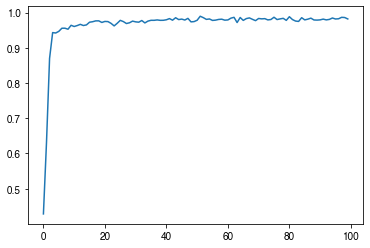

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

152 features selected by RFECV


## Testing

In [15]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
balanced_accuracy_score(test_label, pred_label)

0.992831541218638

## Confusion matrix

In [17]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 6)]

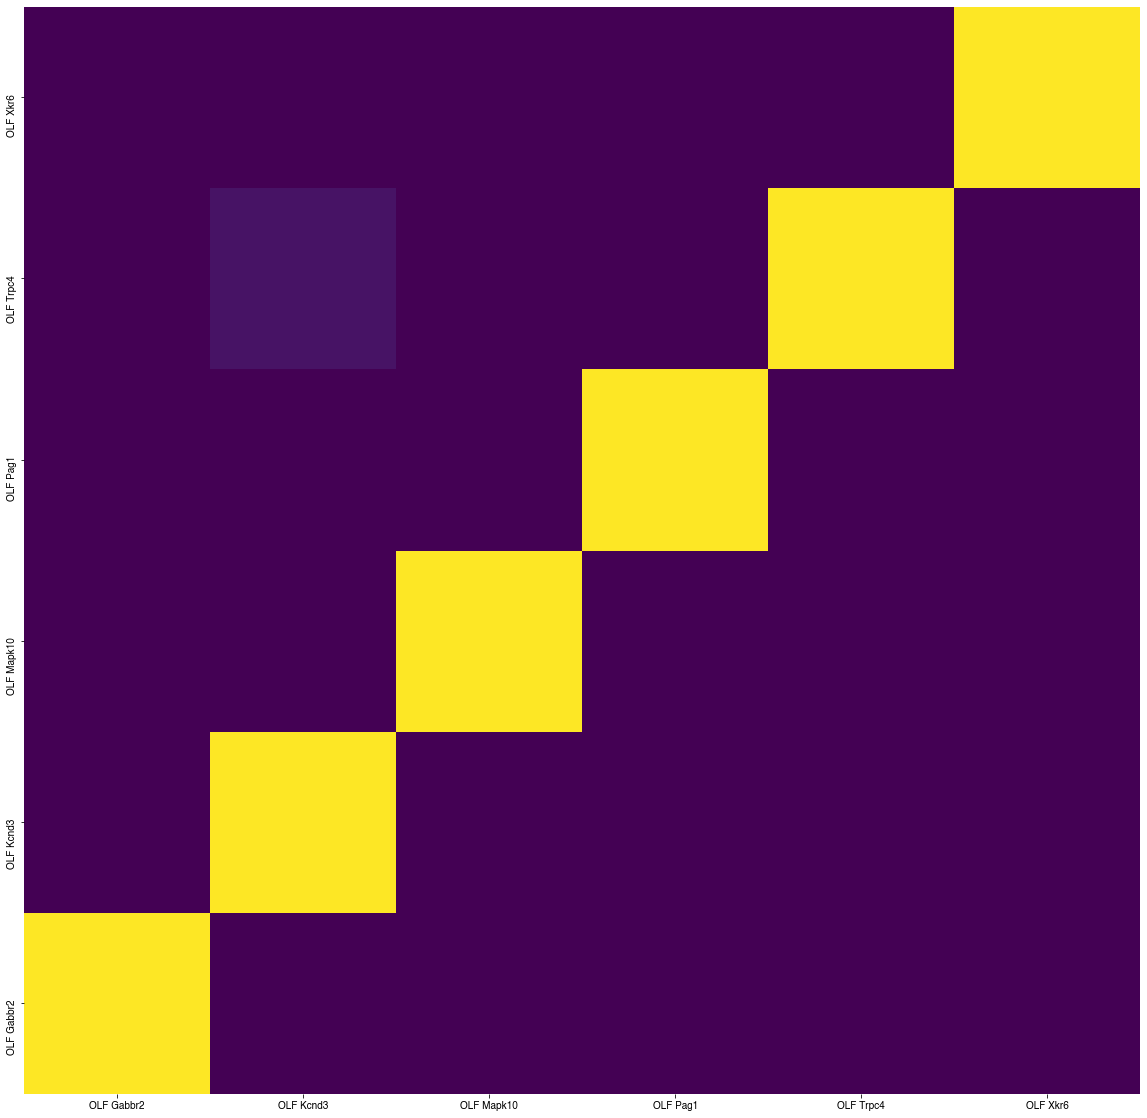

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [19]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

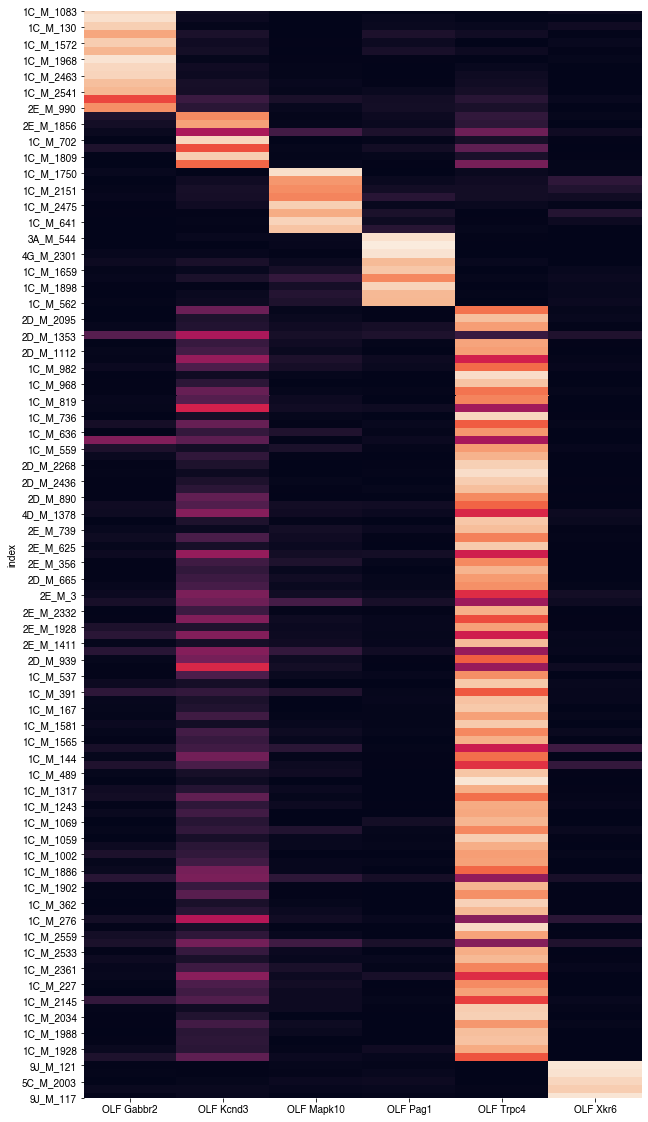

In [20]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

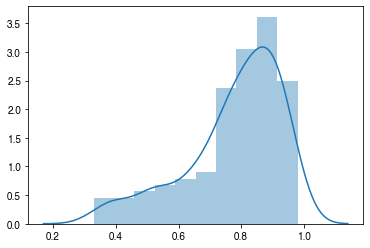

In [21]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [22]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [23]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [24]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 500
building tree 4 of 500
building tree 3 of 500
building tree 8 of 500
building tree 6 of 500
building tree 1 of 500
building tree 5 of 500
building tree 10 of 500
building tree 7 of 500
building tree 12 of 500
building tree 11 of 500
building tree 22 of 500
building tree 9 of 500
building tree 19 of 500
building tree 18 of 500
building tree 17 of 500
building tree 15 of 500
building tree 16 of 500
building tree 21 of 500
building tree 24 of 500
building tree 14 of 500
building tree 27 of 500
building tree 26 of 500
building tree 29 of 500
building tree 13 of 500
building tree 23 of 500
building tree 20 of 500
building tree 28 of 500
building tree 30 of 500
building tree 25 of 500
building tree 31 of 500
building tree 40 of 500
building tree 39 of 500building tree 32 of 500
building tree 35 of 500

building tree 33 of 500
building tree 37 of 500building tree 41 of 500

building tree 36 of 500
building tree 52 of 500
building tree 47 of 500building tree 42 of 500

b


building tree 64 of 500
building tree 70 of 500building tree 73 of 500
building tree 83 of 500
building tree 69 of 500

building tree 76 of 500
building tree 74 of 500
building tree 85 of 500
building tree 77 of 500building tree 87 of 500

building tree 78 of 500building tree 79 of 500building tree 75 of 500

building tree 89 of 500building tree 80 of 500


building tree 82 of 500building tree 88 of 500

building tree 81 of 500
building tree 86 of 500
building tree 84 of 500
building tree 90 of 500
building tree 95 of 500building tree 92 of 500
building tree 93 of 500

building tree 94 of 500building tree 91 of 500
building tree 96 of 500

building tree 97 of 500
building tree 99 of 500
building tree 104 of 500
building tree 101 of 500building tree 100 of 500building tree 98 of 500building tree 102 of 500



building tree 105 of 500
building tree 111 of 500
building tree 103 of 500building tree 107 of 500

building tree 108 of 500
building tree 113 of 500building tree 116 of 500
build

[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.3s


building tree 143 of 500
building tree 139 of 500
building tree 144 of 500
building tree 142 of 500
building tree 147 of 500building tree 145 of 500

building tree 149 of 500
building tree 150 of 500
building tree 148 of 500building tree 152 of 500

building tree 161 of 500building tree 158 of 500

building tree 153 of 500building tree 154 of 500

building tree 156 of 500building tree 151 of 500building tree 163 of 500building tree 155 of 500



building tree 157 of 500building tree 164 of 500
building tree 162 of 500
building tree 160 of 500

building tree 168 of 500building tree 166 of 500

building tree 170 of 500building tree 165 of 500

building tree 169 of 500building tree 159 of 500

building tree 173 of 500building tree 171 of 500

building tree 174 of 500
building tree 167 of 500
building tree 175 of 500
building tree 176 of 500
building tree 180 of 500
building tree 177 of 500building tree 178 of 500

building tree 172 of 500
building tree 181 of 500
building tree 179 of 500


building tree 210 of 500building tree 209 of 500

building tree 215 of 500building tree 217 of 500building tree 213 of 500building tree 216 of 500
building tree 211 of 500

building tree 214 of 500


building tree 223 of 500
building tree 212 of 500building tree 222 of 500
building tree 218 of 500
building tree 219 of 500

building tree 225 of 500building tree 220 of 500building tree 224 of 500


building tree 229 of 500
building tree 228 of 500
building tree 221 of 500building tree 230 of 500

building tree 231 of 500
building tree 226 of 500
building tree 233 of 500
building tree 227 of 500building tree 232 of 500

building tree 234 of 500
building tree 237 of 500building tree 238 of 500building tree 236 of 500


building tree 239 of 500
building tree 235 of 500
building tree 247 of 500
building tree 243 of 500building tree 244 of 500
building tree 249 of 500
building tree 241 of 500building tree 240 of 500building tree 245 of 500



building tree 242 of 500
building tree 254 of 500


[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.7s


building tree 280 of 500
building tree 274 of 500
building tree 272 of 500building tree 281 of 500

building tree 283 of 500
building tree 287 of 500
building tree 285 of 500
building tree 282 of 500building tree 289 of 500

building tree 284 of 500
building tree 288 of 500
building tree 291 of 500building tree 292 of 500building tree 286 of 500


building tree 293 of 500building tree 290 of 500building tree 295 of 500


building tree 294 of 500
building tree 296 of 500
building tree 299 of 500
building tree 298 of 500
building tree 302 of 500building tree 300 of 500

building tree 303 of 500building tree 301 of 500

building tree 297 of 500building tree 307 of 500

building tree 309 of 500
building tree 304 of 500
building tree 312 of 500building tree 311 of 500building tree 306 of 500

building tree 305 of 500

building tree 310 of 500
building tree 314 of 500building tree 316 of 500building tree 308 of 500


building tree 313 of 500
building tree 318 of 500
building tree 324 of 500


building tree 346 of 500
building tree 352 of 500
building tree 343 of 500building tree 350 of 500building tree 342 of 500
building tree 347 of 500
building tree 355 of 500building tree 348 of 500



building tree 337 of 500
building tree 356 of 500building tree 344 of 500building tree 351 of 500


building tree 349 of 500building tree 357 of 500

building tree 353 of 500
building tree 358 of 500
building tree 362 of 500
building tree 361 of 500
building tree 359 of 500
building tree 360 of 500building tree 365 of 500

building tree 364 of 500building tree 363 of 500

building tree 367 of 500
building tree 366 of 500building tree 369 of 500building tree 374 of 500
building tree 375 of 500


building tree 379 of 500
building tree 376 of 500building tree 372 of 500building tree 373 of 500
building tree 371 of 500

building tree 381 of 500building tree 368 of 500


building tree 380 of 500
building tree 370 of 500
building tree 377 of 500
building tree 378 of 500building tree 384 of 500bu

building tree 412 of 500building tree 420 of 500
building tree 418 of 500

building tree 419 of 500
building tree 423 of 500
building tree 417 of 500
building tree 421 of 500
building tree 425 of 500
building tree 426 of 500
building tree 428 of 500building tree 424 of 500

building tree 427 of 500building tree 430 of 500

building tree 432 of 500
building tree 422 of 500building tree 429 of 500building tree 436 of 500


building tree 433 of 500building tree 434 of 500

building tree 442 of 500
building tree 431 of 500building tree 437 of 500

building tree 435 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500building tree 445 of 500
building tree 444 of 500

building tree 443 of 500
building tree 447 of 500
building tree 446 of 500
building tree 449 of 500building tree 451 of 500

building tree 448 of 500building tree 454 of 500building tree 455 of 500
building tree 452 of 500
building tree 453 of 500

building tree 450 of 500
b

building tree 486 of 500building tree 483 of 500

building tree 487 of 500
building tree 491 of 500building tree 489 of 500

building tree 490 of 500building tree 496 of 500
building tree 493 of 500
building tree 492 of 500

building tree 488 of 500
building tree 494 of 500
building tree 497 of 500
building tree 500 of 500
building tree 498 of 500
building tree 495 of 500
building tree 499 of 500


[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    1.5s finished


['Model/FinalClassifier.lib']

## Final Pred

In [25]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


In [26]:
balanced_accuracy_score(test_label, final_pred_label)

0.992831541218638

## Final evaluate

In [27]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 6)]

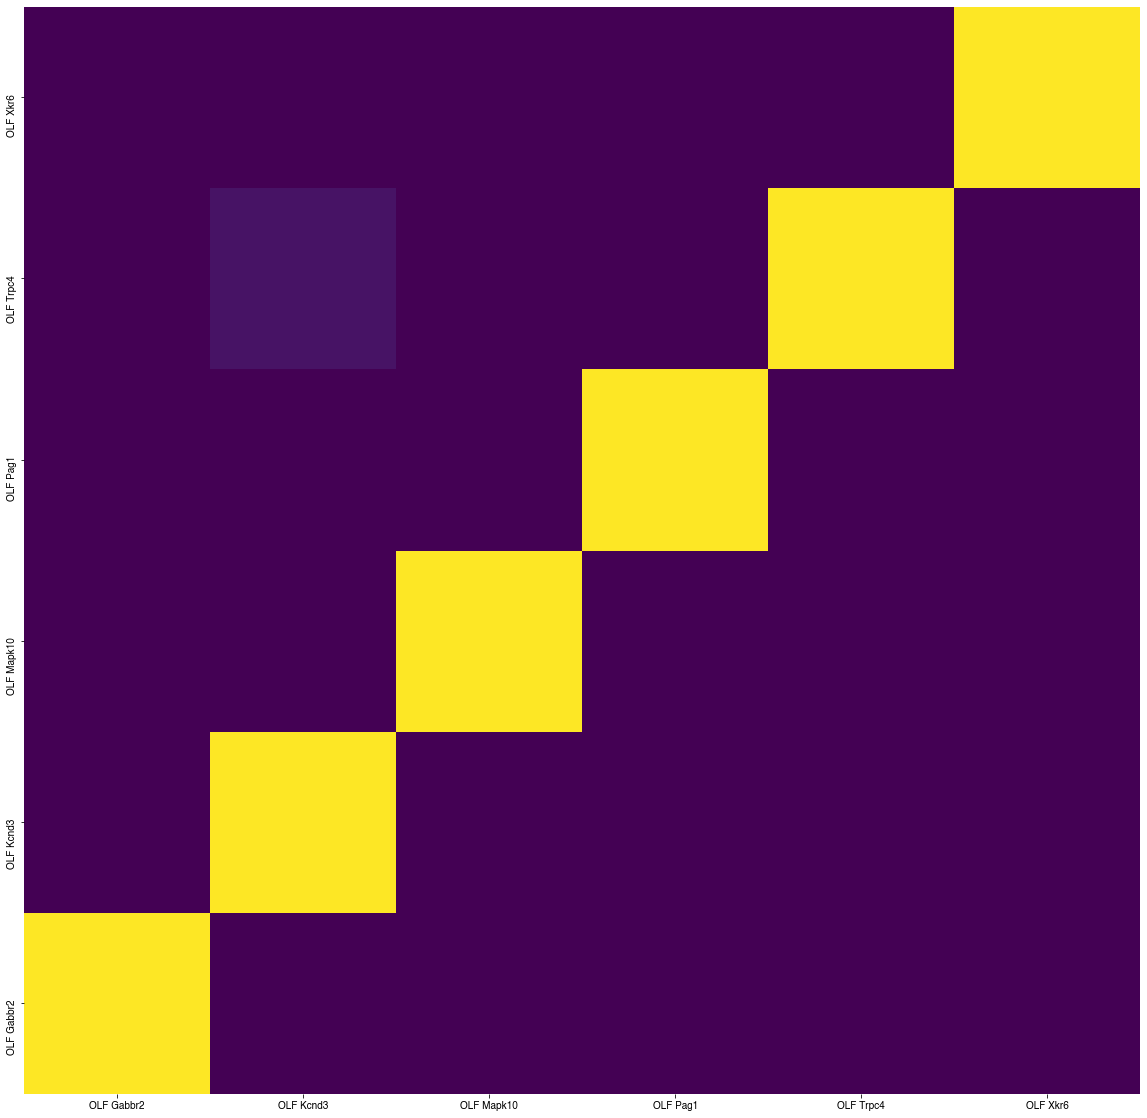

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [29]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

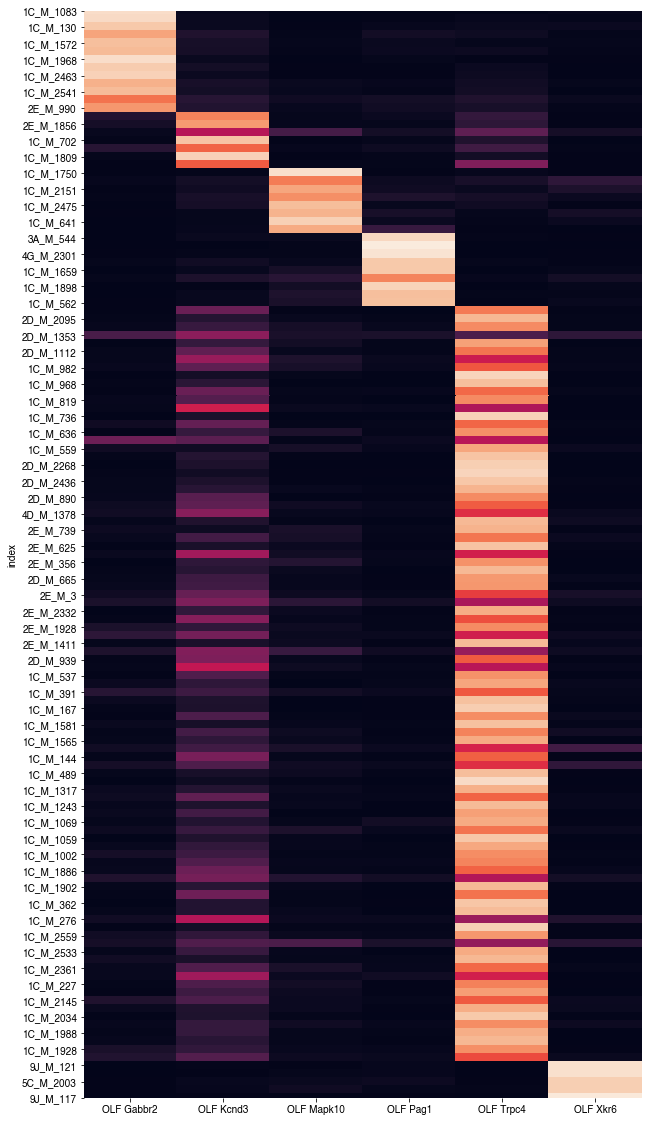

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

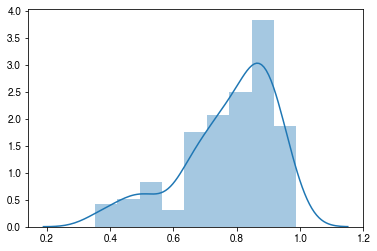

In [31]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [32]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')